## Global Clustering of Defenders: Serie A, Ligue 1 & La Liga (2023–24)

This notebook brings together defender data from Serie A, Ligue 1, and La Liga to construct a role-based clustering model across leagues.  
The aim is to uncover tactical defender archetypes based on their defensive involvement, distribution quality, press resistance, and zone coverage.


### League-Level Preprocessing

Each league’s dataset was individually preprocessed to ensure analytical consistency:
- Standardized raw columns and identifiers  
- Filtered for defenders with ≥540 minutes played  
- Retained `name`, `team`, `league`, and `position` for traceability  
- One-hot encoded team context to preserve tactical environment


### Tactical Metric Selection

Selected features focus on defensive reliability, technical execution, and zone-specific coverage:

**Defensive Output**  
- tackles, interceptions, blocks, clearances  
- Includes both standard and FBref-derived stats  
- Zone-specific actions: defensive, middle, attacking thirds

**Duel Efficiency**  
- duels total and won → engineered win percentage

**Distribution Accuracy**  
- short, medium, and long pass completion percentages

**Reliability Indicators**  
- dribbled past frequency, passes blocked, shots blocked

**Attacking/Transitional Signals**  
- goals and assists  
- ball carry metrics (dribblers tackled success rate)

### Clustering Pipeline

In this notebook, the following steps will be executed:

1. Merge defender datasets from all three leagues  
2. Engineer efficiency metrics and scale tactical features  
3. Apply PCA to reduce dimensionality while preserving tactical signal  
4. Run K-Means clustering to identify role-based stylistic groups  
5. Interpret clusters using centroid analysis and descriptive summaries


This approach enables the detection of tactical defender roles—such as distribution-focused centre backs, high-pressure stoppers, aggressive fullbacks, or hybrid wide defenders—allowing cross-league comparisons beyond traditional positions or formations.


Firstly, I am ensuring that all columns are the same for each league's dataset.I also added the 'league' column on each dataset.

In [1]:
import pandas as pd

# --- Load and tag Serie A defender dataset ---
df_seriea = pd.read_csv("seriea_defenders_2023_24_preprocessed_encoded_team.csv")
df_seriea["league"] = "Serie A"

# --- Load and tag Ligue 1 defender dataset ---
df_ligue1 = pd.read_csv("ligue1_defenders_2023_24_preprocessed_encoded_team.csv")
df_ligue1["league"] = "Ligue 1"

# --- Load and tag La Liga defender dataset ---
df_laliga = pd.read_csv("laliga_defenders_2023_24_preprocessed_encoded_team.csv")
df_laliga["league"] = "La Liga"

# --- Print column names for inspection ---
print("\nSerie A columns:")
print(df_seriea.columns.to_list())

print("\nLigue 1 columns:")
print(df_ligue1.columns.to_list())

print("\nLa Liga columns:")
print(df_laliga.columns.to_list())

# --- Preview sample rows with traceability fields and a few tactical metrics ---
print("\nSerie A sample:")
print(df_seriea[["name", "team_clean", "league", "duels_total_p90", "interceptions_p90"]].head(2).to_string())

print("\nLigue 1 sample:")
print(df_ligue1[["name", "team_clean", "league", "duels_total_p90", "interceptions_p90"]].head(2).to_string())

print("\nLa Liga sample:")
print(df_laliga[["name", "team_clean", "league", "duels_total_p90", "interceptions_p90"]].head(2).to_string())



Serie A columns:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total', 'shots_total', 'shots_on_target', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_total_api', 'passes_total_accuracy_api', 'tackles_api', 'interceptions_api', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'player_name_fbref', 'nation_fbref', '90s_played_fbref', 'passes_completed_total_fbref', 'passes_short_cmp_fbref', 'passes_short_att_fbref', 'passes_short_acc_fbref', 'passes_medium_cmp_fbref', 'passes_medium_att_fbref', 'passes_medium_acc_fbref', 'passes_long_cmp_fbref', 'passes_long_att_fbref', 'passes_long_acc_fbref', 'assists_fbref_total', 'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'tackles_total_fbref', 'tackles_won_total_fbref', 'tackles_def_3rd_total_fbref', 'tackles_mid_3rd_total_fbref', 'tackles_att_3rd_total_fbref', 'dribblers_tackled_total_fbref', 'dribblers_tackled_success_perc_fbref', 'dribbled_p

Before merging or scaling the forward datasets, I’m checking each one for missing values. This helps identify any columns that need to be dropped, imputed, or handled carefully to avoid errors in clustering or PCA.

In [2]:
# --- Inspect missing values in Serie A defenders ---
print("\nMissing values in Serie A defenders:")
print(df_seriea.isnull().sum().sort_values(ascending=False))

# --- Inspect missing values in Ligue 1 defenders ---
print("\nMissing values in Ligue 1 defenders:")
print(df_ligue1.isnull().sum().sort_values(ascending=False))

# --- Inspect missing values in La Liga defenders ---
print("\nMissing values in La Liga defenders:")
print(df_laliga.isnull().sum().sort_values(ascending=False))



Missing values in Serie A defenders:
name               0
position           0
minutes            0
duels_total_api    0
duels_won_api      0
                  ..
team_Sassuolo      0
team_Torino        0
team_Udinese       0
team_Verona        0
league             0
Length: 100, dtype: int64

Missing values in Ligue 1 defenders:
name                      0
position                  0
minutes                   0
duels_total_api           0
duels_won_api             0
                         ..
team_Rennes               0
team_Stade Brestois 29    0
team_Strasbourg           0
team_Toulouse             0
league                    0
Length: 98, dtype: int64

Missing values in La Liga defenders:
name                  0
position              0
minutes               0
duels_total_api       0
duels_won_api         0
                     ..
team_Real Sociedad    0
team_Sevilla          0
team_Valencia         0
team_Villarreal       0
league                0
Length: 91, dtype: int64


O missing values.

#1. Merging the 3 datasets

With all three league datasets cleaned and consistently labeled, I’m now merging them into one global DataFrame. This combined pool includes all preprocessed metrics, one-hot encoded team flags, and identifiers like name, team_clean, and league. It’s the foundation for global feature scaling and clustering.

In [3]:
import pandas as pd

# --- Load preprocessed, team-encoded defender datasets ---
df_seriea = pd.read_csv("seriea_defenders_2023_24_preprocessed_encoded_team.csv")
df_ligue1 = pd.read_csv("ligue1_defenders_2023_24_preprocessed_encoded_team.csv")
df_laliga = pd.read_csv("laliga_defenders_2023_24_preprocessed_encoded_team.csv")

# --- Add league identifiers manually (for traceability during clustering)
df_seriea["league"] = "Serie A"
df_ligue1["league"] = "Ligue 1"
df_laliga["league"] = "La Liga"

# --- Merge datasets into a unified global dataframe
df_global_defenders_raw = pd.concat([df_seriea, df_ligue1, df_laliga], ignore_index=True)

# --- Save merged output to file
df_global_defenders_raw.to_csv("global_defenders_2023_24_encoded.csv", index=False)
print(f"✅ Global defender dataset saved — shape: {df_global_defenders_raw.shape}")

# --- Sanity check sample
print(df_global_defenders_raw[["name", "team_clean", "league", "duels_total_p90", "interceptions_p90", "league"]].head())


✅ Global defender dataset saved — shape: (262, 134)
            name   team_clean   league  duels_total_p90  interceptions_p90  \
0       F. Fazio  salernitana  Serie A         7.771218           1.129151   
1      Mário Rui       napoli  Serie A         9.395195           1.118476   
2  D. D'Ambrosio        monza  Serie A         9.628180           0.821918   
3  Pedro Pereira        monza  Serie A         7.338129           0.431655   
4    A. Florenzi        milan  Serie A         6.558704           1.041064   

    league  
0  Serie A  
1  Serie A  
2  Serie A  
3  Serie A  
4  Serie A  


#2. EDA (EXPLORATORY DATA ANALYSIS)

Before initiating PCA and clustering, this section provides a tactical overview of the global defenders dataset for the 2023–24 season. It summarizes key performance metrics—normalized per 90 minutes or expressed as percentages—and inspects missing values, average contributions, and metric classifications. By reviewing variables like goals, shot volume, passing, dribbling, and duels across leagues, we establish a contextual foundation to interpret cluster results and ensure modeling transparency.

In [4]:
import pandas as pd

# --- Load the encoded global defender dataset ---
try:
    df_global_encoded = pd.read_csv("global_defenders_2023_24_encoded.csv")
    print("✅ Global defender dataset loaded successfully for EDA overview.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Section Intro ---
print("\n# 2. EDA (Exploratory Data Analysis)")
print("## 2.1 Tactical Overview of Global Defender Pool")
print("This section previews identifiers and contribution metrics used for clustering, checking structure, completeness, and average values across the dataset.")

# --- Identifier Columns ---
identifier_columns = [
    "name", "name_clean", "team", "team_clean", "league", "minutes", "position"
]

print("\n### Identifier Variables:")
existing_ids = [col for col in identifier_columns if col in df_global_encoded.columns]
for col in existing_ids:
    print(f"    * {col}")

# --- Defender Clustering Metrics ---
clustering_metrics = [
    "duels_total_p90", "duels_won_p90", "interceptions_p90", "interceptions_p90_fbref",
    "tackles_p90", "tackles_p90_fbref", "tackles_won_p90_fbref", "tackles_interceptions_p90_fbref",
    "blocks_p90_fbref", "shots_blocked_p90_fbref", "passes_blocked_p90_fbref",
    "clearances_p90_fbref", "dribbled_past_p90_fbref",
    "passes_short_acc_fbref", "passes_medium_acc_fbref", "passes_long_acc_fbref",
    "goals_p90", "assists_p90_fbref", "dribblers_tackled_success_perc_fbref",
    "dribblers_tackled_p90_fbref", "tackles_def_3rd_p90_fbref",
    "tackles_mid_3rd_p90_fbref", "tackles_att_3rd_p90_fbref"
]

print("\n### Performance Metrics Used for Clustering:")
existing_metrics = [col for col in clustering_metrics if col in df_global_encoded.columns]
for metric in existing_metrics:
    print(f"    * {metric}")

# --- Dataset Dimensions ---
print(f"\n### Dataset Overview:")
print(f"    * Total Players: {df_global_encoded.shape[0]}")
print(f"    * Total Columns: {df_global_encoded.shape[1]}")

# --- Missing Values Check (Safeguarded) ---
missing_check_cols = existing_ids + existing_metrics
missing_values = df_global_encoded[missing_check_cols].isnull().sum()
missing_summary = missing_values[missing_values > 0]

if missing_summary.empty:
    print("    ✅ No missing values detected in key columns.")
else:
    print("    ⚠️ Missing values found:")
    print(missing_summary.to_string())

# --- Mean Values of Clustering Metrics ---
print("\n### Mean Contribution Metrics Across Global Pool:")
for metric in existing_metrics:
    avg = df_global_encoded[metric].mean()
    unit = "%" if "perc" in metric or "acc" in metric else ""
    print(f"    * {metric}: {avg:.2f}{unit}")


✅ Global defender dataset loaded successfully for EDA overview.

# 2. EDA (Exploratory Data Analysis)
## 2.1 Tactical Overview of Global Defender Pool
This section previews identifiers and contribution metrics used for clustering, checking structure, completeness, and average values across the dataset.

### Identifier Variables:
    * name
    * name_clean
    * team_clean
    * league
    * minutes
    * position

### Performance Metrics Used for Clustering:
    * duels_total_p90
    * duels_won_p90
    * interceptions_p90
    * interceptions_p90_fbref
    * tackles_p90
    * tackles_p90_fbref
    * tackles_won_p90_fbref
    * tackles_interceptions_p90_fbref
    * blocks_p90_fbref
    * shots_blocked_p90_fbref
    * passes_blocked_p90_fbref
    * clearances_p90_fbref
    * dribbled_past_p90_fbref
    * passes_short_acc_fbref
    * passes_medium_acc_fbref
    * passes_long_acc_fbref
    * goals_p90
    * assists_p90_fbref
    * dribblers_tackled_success_perc_fbref
    * dribblers_tackl

## 2.1 EDA – GLOBAL DEFENDERS  

### Variable Type Classification & Overview – DEFENDERS  

As I move into the Exploratory Data Analysis (EDA) phase for the defender pool across Serie A, Ligue 1, and La Liga, it’s important to classify variables into functional categories. This sets the foundation for clustering and tactical interpretation.


### Variable Type Classification  

**Identifier Variables**  
These variables help identify individual players and preserve traceability during cluster interpretation and visualizations:  
- `name` (original player name from source)  
- `name_clean` (cleaned version for merging)  
- `team_clean` (standardized team label)  
- `league` (league identifier)  
- `minutes` (total minutes played — used for filtering)  
- `position` (categorical, excluded from clustering but useful for labeling)


### Tactical Metrics for Clustering (Numerical Variables)  

All selected metrics are either normalized per 90 minutes or are expressed as percentages, ensuring fair comparison across players:

**Duel Output**  
- `duels_total_p90`  
- `duels_won_p90`  
→ Will be converted into duel win rate later

**Defensive Involvement**  
- `interceptions_p90`  
- `interceptions_p90_fbref`  
- `tackles_p90`  
- `tackles_p90_fbref`  
- `tackles_won_p90_fbref`  
- `tackles_interceptions_p90_fbref`  
- `clearances_p90_fbref`  
- `blocks_p90_fbref`  
- `shots_blocked_p90_fbref`  
- `passes_blocked_p90_fbref`  
- `dribbled_past_p90_fbref`

**Zone-Specific Defensive Actions**  
- `tackles_def_3rd_p90_fbref`  
- `tackles_mid_3rd_p90_fbref`  
- `tackles_att_3rd_p90_fbref`

**Distribution Accuracy**  
- `passes_short_acc_fbref`  
- `passes_medium_acc_fbref`  
- `passes_long_acc_fbref`  
→ These help differentiate build-up anchors from conservative clearers

**Transitional or Offensive Contribution**  
- `dribblers_tackled_success_perc_fbref`  
- `dribblers_tackled_p90_fbref`  
- `goals_p90`  
- `assists_p90_fbref`  
→ Helps identify overlapping fullbacks or aggressive outlet profiles


### Dataset Overview  
- Total Players: **262**  
- Total Columns: **134**  
- ✅ No missing values detected in key clustering columns


### Mean Contribution Metrics Across Global Pool  
- `duels_total_p90`: 8.55  
- `duels_won_p90`: 4.67  
- `interceptions_p90`: 1.09  
- `interceptions_p90_fbref`: 1.08  
- `tackles_p90`: 1.83  
- `tackles_p90_fbref`: 1.83  
- `tackles_won_p90_fbref`: 1.12  
- `tackles_interceptions_p90_fbref`: 2.92  
- `blocks_p90_fbref`: 1.25  
- `shots_blocked_p90_fbref`: 0.51  
- `passes_blocked_p90_fbref`: 0.74  
- `clearances_p90_fbref`: 3.02  
- `dribbled_past_p90_fbref`: 0.70  
- `passes_short_acc_fbref`: 88.58%  
- `passes_medium_acc_fbref`: 84.83%  
- `passes_long_acc_fbref`: 54.53%  
- `goals_p90`: 0.05  
- `assists_p90_fbref`: 0.04  
- `dribblers_tackled_success_perc_fbref`: 58.68%  
- `dribblers_tackled_p90_fbref`: 0.97  
- `tackles_def_3rd_p90_fbref`: 1.08  
- `tackles_mid_3rd_p90_fbref`: 0.59  
- `tackles_att_3rd_p90_fbref`: 0.16  


The completeness and coverage across leagues suggest a strong base for clustering. Distribution and zone-specific tackling will be key axes for tactical separation.


Following I am plotting distributions of key metrics for defenders to understand typical player behavior and detect skewness. These visualizations help us grasp how common or rare certain statistical outputs are for defenders.

✅ Encoded global defender dataset loaded for metric distribution plots.


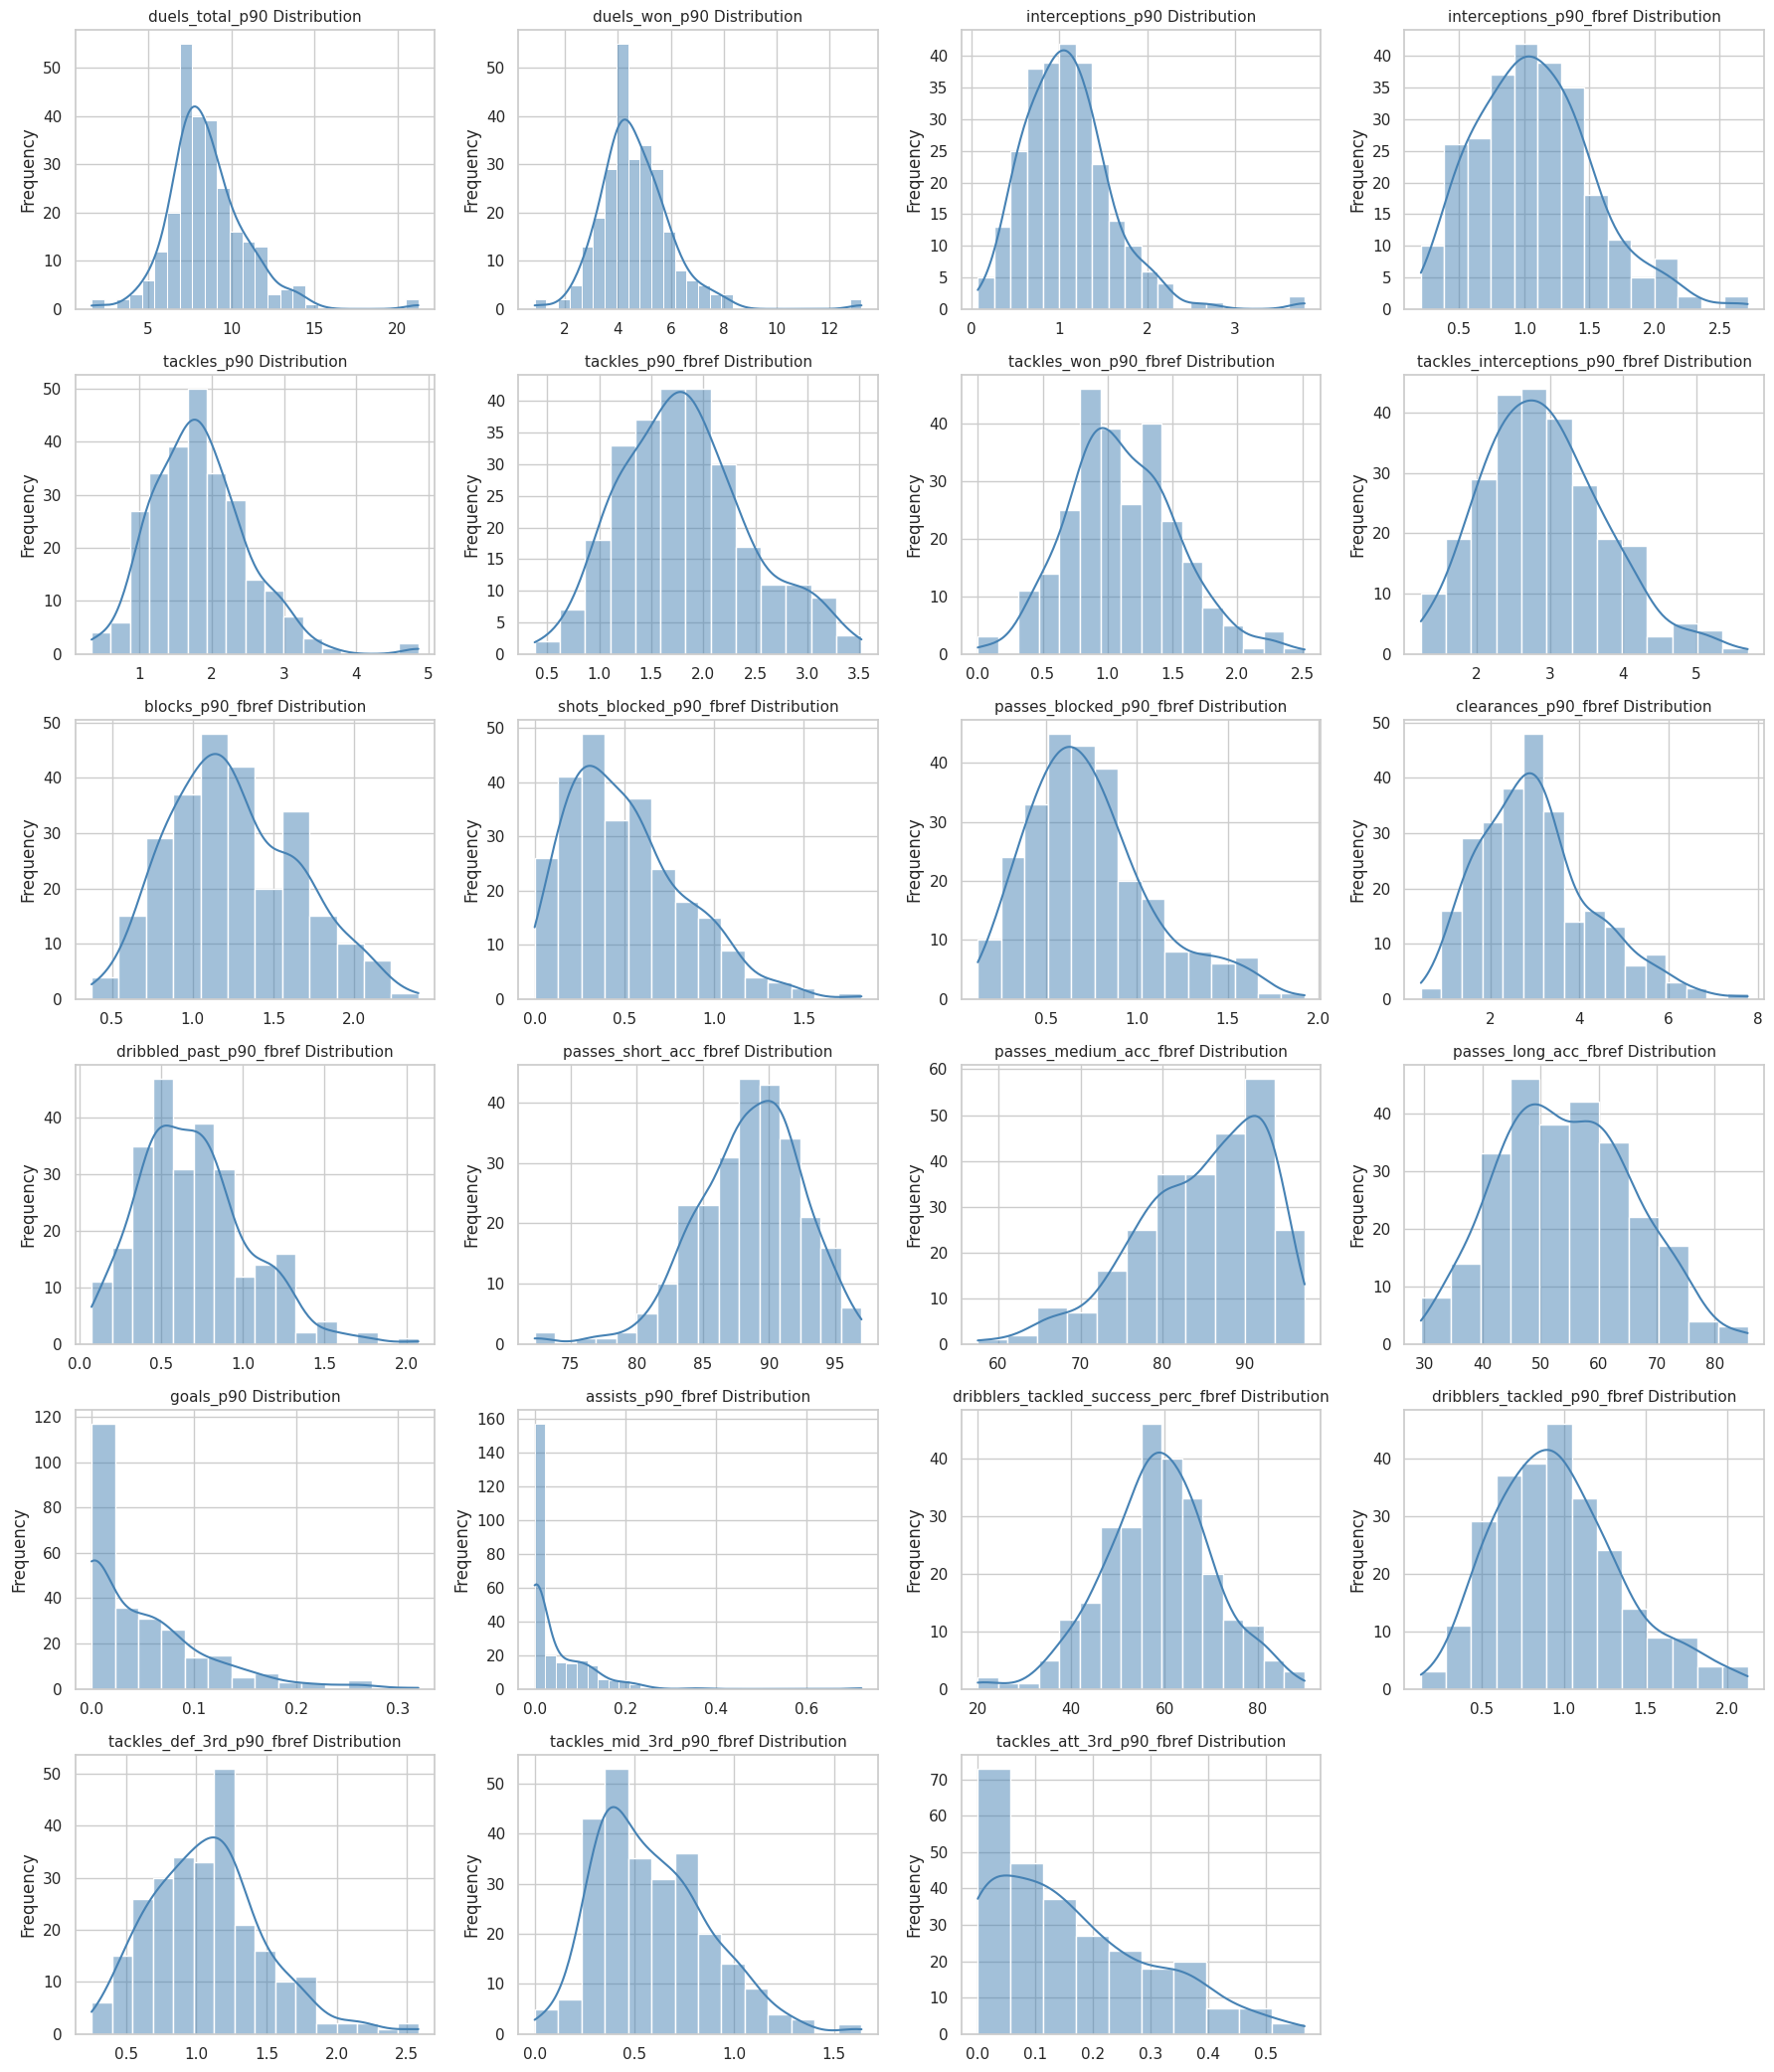

✅ Distribution plots for global defender metrics generated successfully.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Set Seaborn visual style ---
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 14)

# --- Load the encoded global defender dataset ---
try:
    df_global_encoded = pd.read_csv("global_defenders_2023_24_encoded.csv")
    print("✅ Encoded global defender dataset loaded for metric distribution plots.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define performance metrics used in clustering ---
key_metrics = [
    "duels_total_p90", "duels_won_p90", "interceptions_p90", "interceptions_p90_fbref",
    "tackles_p90", "tackles_p90_fbref", "tackles_won_p90_fbref", "tackles_interceptions_p90_fbref",
    "blocks_p90_fbref", "shots_blocked_p90_fbref", "passes_blocked_p90_fbref",
    "clearances_p90_fbref", "dribbled_past_p90_fbref",
    "passes_short_acc_fbref", "passes_medium_acc_fbref", "passes_long_acc_fbref",
    "goals_p90", "assists_p90_fbref", "dribblers_tackled_success_perc_fbref",
    "dribblers_tackled_p90_fbref", "tackles_def_3rd_p90_fbref",
    "tackles_mid_3rd_p90_fbref", "tackles_att_3rd_p90_fbref"
]

# --- Create subplot grid ---
num_metrics = len(key_metrics)
ncols = 4
nrows = (num_metrics + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
axes = axes.flatten()

# --- Plot each feature with KDE overlay ---
for i, metric in enumerate(key_metrics):
    if metric in df_global_encoded.columns:
        sns.histplot(data=df_global_encoded, x=metric, kde=True, ax=axes[i], color='steelblue')
        axes[i].set_title(f"{metric} Distribution", fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frequency")
    else:
        print(f"⚠️ '{metric}' not found in dataset. Skipping.")
        fig.delaxes(axes[i])

# --- Remove empty axes if any ---
for j in range(num_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("✅ Distribution plots for global defender metrics generated successfully.")


## Key Takeaways from the Distribution Plots – Global Defenders
These visualizations provide insights into how the filtered group of global defenders (Serie A, Ligue 1, and La Liga) operate across the pitch, highlighting their contributions in defending, ball circulation, progression, and attacking output.

### Defensive Actions

**duels_total_p90** and **duels_won_p90**: These distributions appear somewhat right-skewed, indicating that while most defenders engage in a moderate number of defensive actions, there's a smaller group of players who are significantly more active defensively. This suggests distinct roles within the defense in terms of defensive contribution across the three leagues.

**tackles_p90**, **interceptions_p90**: These distributions show variations in defensive contribution through direct action and anticipation. Most global defenders perform a relatively low number of tackles and interceptions per 90. However, the distributions show tails extending to higher values, identifying players who are more proactive in regaining possession through tackles and reading the game for interceptions.

**blocks_p90_fbref**, **clearances_p90_fbref**, **shots_blocked_p90_fbref**, **passes_blocked_p90_fbref**: These distributions are heavily skewed to the right, indicating that while most defenders perform a relatively low number of blocks, clearances, and shots/passes blocked per 90, there are outliers who are significantly more active in these areas. This highlights players who are more involved in disrupting opposition attacks and clearing the ball from dangerous areas.

**dribbled_past_p90_fbref**: This metric shows a right-skewed distribution, with most defenders being dribbled past a low number of times per 90. There are some players who are dribbled past more frequently, which could indicate different defensive styles or positions.

**tackles_def_3rd_p90_fbref**, **tackles_mid_3rd_p90_fbref**, **tackles_att_3rd_p90_fbref**: The distributions for tackles in different thirds of the pitch are all right-skewed, with most tackles occurring in the defensive and middle thirds. Tackles in the attacking third are less frequent, as expected for defenders.

### Ball Circulation and Volume

**passes_short_acc_fbref**, **passes_medium_acc_fbref**, **passes_long_acc_fbref**: The distributions for passing accuracy show that most defenders have high accuracy for short and medium passes, with a wider spread for long passes. This suggests that while defenders are generally reliable in short and medium range distribution, long passing is a more variable skill.

### Transitional or Offensive Contribution

**goals_p90** and **assists_p90_fbref**: These distributions are heavily skewed to the right, indicating that most defenders contribute very few goals or assists per 90. The tails of the distributions show a small number of defenders who are significantly more involved in attacking phases, likely fullbacks or set-piece takers.

**dribblers_tackled_success_perc_fbref** and **dribblers_tackled_p90_fbref**: The success percentage shows a relatively wide distribution, suggesting variability in how effective defenders are at tackling dribblers. The number of dribblers tackled per 90 is right-skewed, indicating that some defenders engage with dribblers more frequently than others.

The distributions reveal the diverse roles and contributions of defenders across these leagues, from those focused on high-volume defensive actions to those more involved in ball distribution and even limited attacking output. This information is crucial for informing the feature selection and interpretation of the clustering results.

I am creating a heatmap to visualize correlations between tactical features

-This helps identify which stats tend to move together and which ones are independent

-Useful to understand potential clusters and avoid feature redundancy

✅ Encoded global defender dataset loaded successfully for correlation analysis.


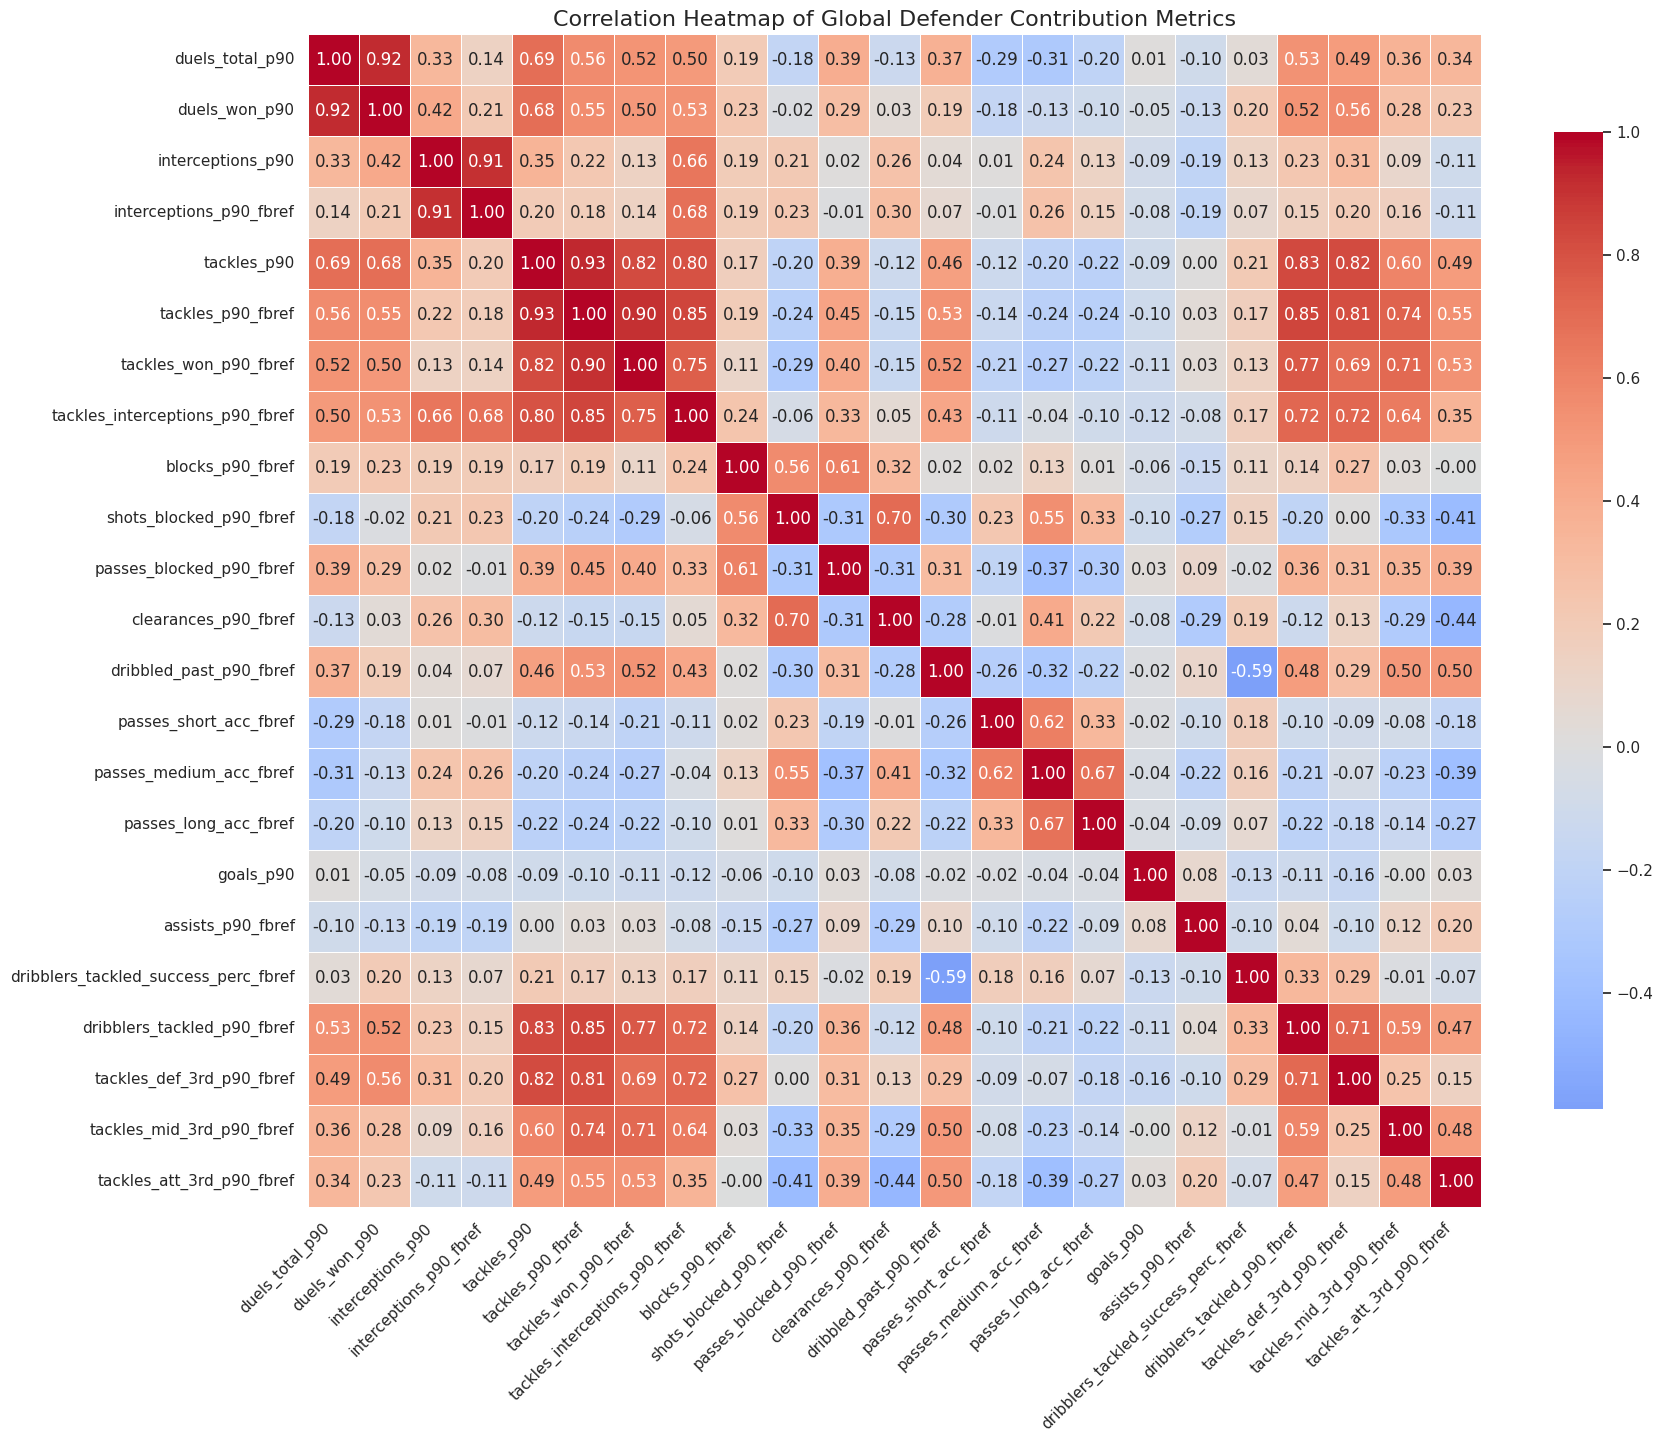

✅ Correlation heatmap for defender metrics generated successfully.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Set Seaborn style ---
sns.set(style="whitegrid")

# --- Load encoded global defender dataset ---
try:
    df_global_encoded = pd.read_csv("global_defenders_2023_24_encoded.csv")
    print("✅ Encoded global defender dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Define relevant metrics for clustering ---
corr_metrics = [
    "duels_total_p90", "duels_won_p90", "interceptions_p90", "interceptions_p90_fbref",
    "tackles_p90", "tackles_p90_fbref", "tackles_won_p90_fbref", "tackles_interceptions_p90_fbref",
    "blocks_p90_fbref", "shots_blocked_p90_fbref", "passes_blocked_p90_fbref",
    "clearances_p90_fbref", "dribbled_past_p90_fbref",
    "passes_short_acc_fbref", "passes_medium_acc_fbref", "passes_long_acc_fbref",
    "goals_p90", "assists_p90_fbref", "dribblers_tackled_success_perc_fbref",
    "dribblers_tackled_p90_fbref", "tackles_def_3rd_p90_fbref",
    "tackles_mid_3rd_p90_fbref", "tackles_att_3rd_p90_fbref"
]

# --- Safeguard: Retain only valid columns present in the dataset ---
valid_corr_metrics = [m for m in corr_metrics if m in df_global_encoded.columns]

if not valid_corr_metrics:
    print("❌ No valid metrics found for correlation analysis.")
else:
    # --- Compute and plot correlation matrix ---
    corr_matrix = df_global_encoded[valid_corr_metrics].corr()

    plt.figure(figsize=(18, 16))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt=".2f",
        square=True,
        linewidths=0.4,
        cbar_kws={"shrink": 0.7}
    )
    plt.title("Correlation Heatmap of Global Defender Contribution Metrics", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("✅ Correlation heatmap for defender metrics generated successfully.")


## Interpretation of the Correlation Heatmap – Global Defenders
The heatmap visualizes the pairwise correlations between the selected per-90 and percentage metrics for global defenders. The values range from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no correlation.

Here are some key observations:

**Strong Positive Correlations:**

*   **duels_total_p90** and **duels_won_p90**: As expected, there is a very strong positive correlation (around 0.92) between the total number of duels a player is involved in and the number of duels they win. This suggests that players who engage in more duels also tend to win a proportional number of them.
*   **interceptions_p90** and **interceptions_p90_fbref**: There is a very strong positive correlation (around 0.91), indicating consistency between the two sources for this metric.
*   **tackles_p90** and **tackles_p90_fbref**: Another very strong positive correlation (around 0.93) showing consistency between sources for tackles.
*   **tackles_p90** and **dribblers_tackled_p90_fbref**: Strong positive correlation (around 0.83) indicates that players who make more tackles also tend to tackle more dribblers.
*   **tackles_p90** and **tackles_def_3rd_p90_fbref**: Strong positive correlation (around 0.82) shows that a significant portion of tackles occur in the defensive third.
*   **tackles_p90_fbref** and **dribblers_tackled_p90_fbref**: Strong positive correlation (around 0.85).
*   **tackles_won_p90_fbref** and **dribblers_tackled_p90_fbref**: Strong positive correlation (around 0.77) suggesting that defenders who win more tackles also tend to be more successful at tackling dribblers.

**Moderate Positive Correlations:**

*   **duels_total_p90** and **tackles_p90**: Moderate positive correlation (around 0.69).
*   **duels_won_p90** and **tackles_p90**: Moderate positive correlation (around 0.68).
*   **interceptions_p90** and **tackles_interceptions_p90_fbref**: Moderate positive correlation (around 0.66).
*   **tackles_p90** and **tackles_interceptions_p90_fbref**: Moderate positive correlation (around 0.80).
*   **tackles_p90_fbref** and **tackles_won_p90_fbref**: Moderate positive correlation (around 0.82).
*   **tackles_p90_fbref** and **tackles_interceptions_p90_fbref**: Moderate positive correlation (around 0.81).
*   **tackles_won_p90_fbref** and **tackles_interceptions_p90_fbref**: Moderate positive correlation (around 0.72).
*   **dribbled_past_p90_fbref** and **tackles_mid_3rd_p90_fbref**: Moderate positive correlation (around 0.50).
*   **dribbled_past_p90_fbref** and **tacklers_att_3rd_p90_fbref**: Moderate positive correlation (around 0.50).
*   **tackles_mid_3rd_p90_fbref** and **tackles_att_3rd_p90_fbref**: Moderate positive correlation (around 0.48).

**Moderate Negative Correlations:**

*   **dribbled_past_p90_fbref** and **dribblers_tackled_success_perc_fbref**: Moderate negative correlation (around -0.59), indicating that players who are dribbled past less frequently tend to have a higher success rate when tackling dribblers.
*   **clearances_p90_fbref** and **tackles_att_3rd_p90_fbref**: Moderate negative correlation (around -0.44), suggesting that defenders who make more clearances tend to make fewer tackles in the attacking third.
*   **shots_blocked_p90_fbref** and **tackles_att_3rd_p90_fbref**: Moderate negative correlation (around -0.41).
*   **passes_medium_acc_fbref** and **tackles_att_3rd_p90_fbref**: Moderate negative correlation (around -0.39).

These correlations highlight the interconnectedness of defensive actions and also suggest that certain defensive styles (e.g., high-pressing vs. deep defending) are reflected in the data. Passing accuracy metrics show weaker correlations with most defensive stats, suggesting that distribution is a more independent aspect of a defender's profile.

I am plotting boxplots to detect outliers and visualize distribution spread.
This helps identify which players (or roles) stand out significantly from the average behavior.

✅ Encoded global defender dataset loaded successfully for boxplot analysis.

--- Generating Boxplot Visualizations ---


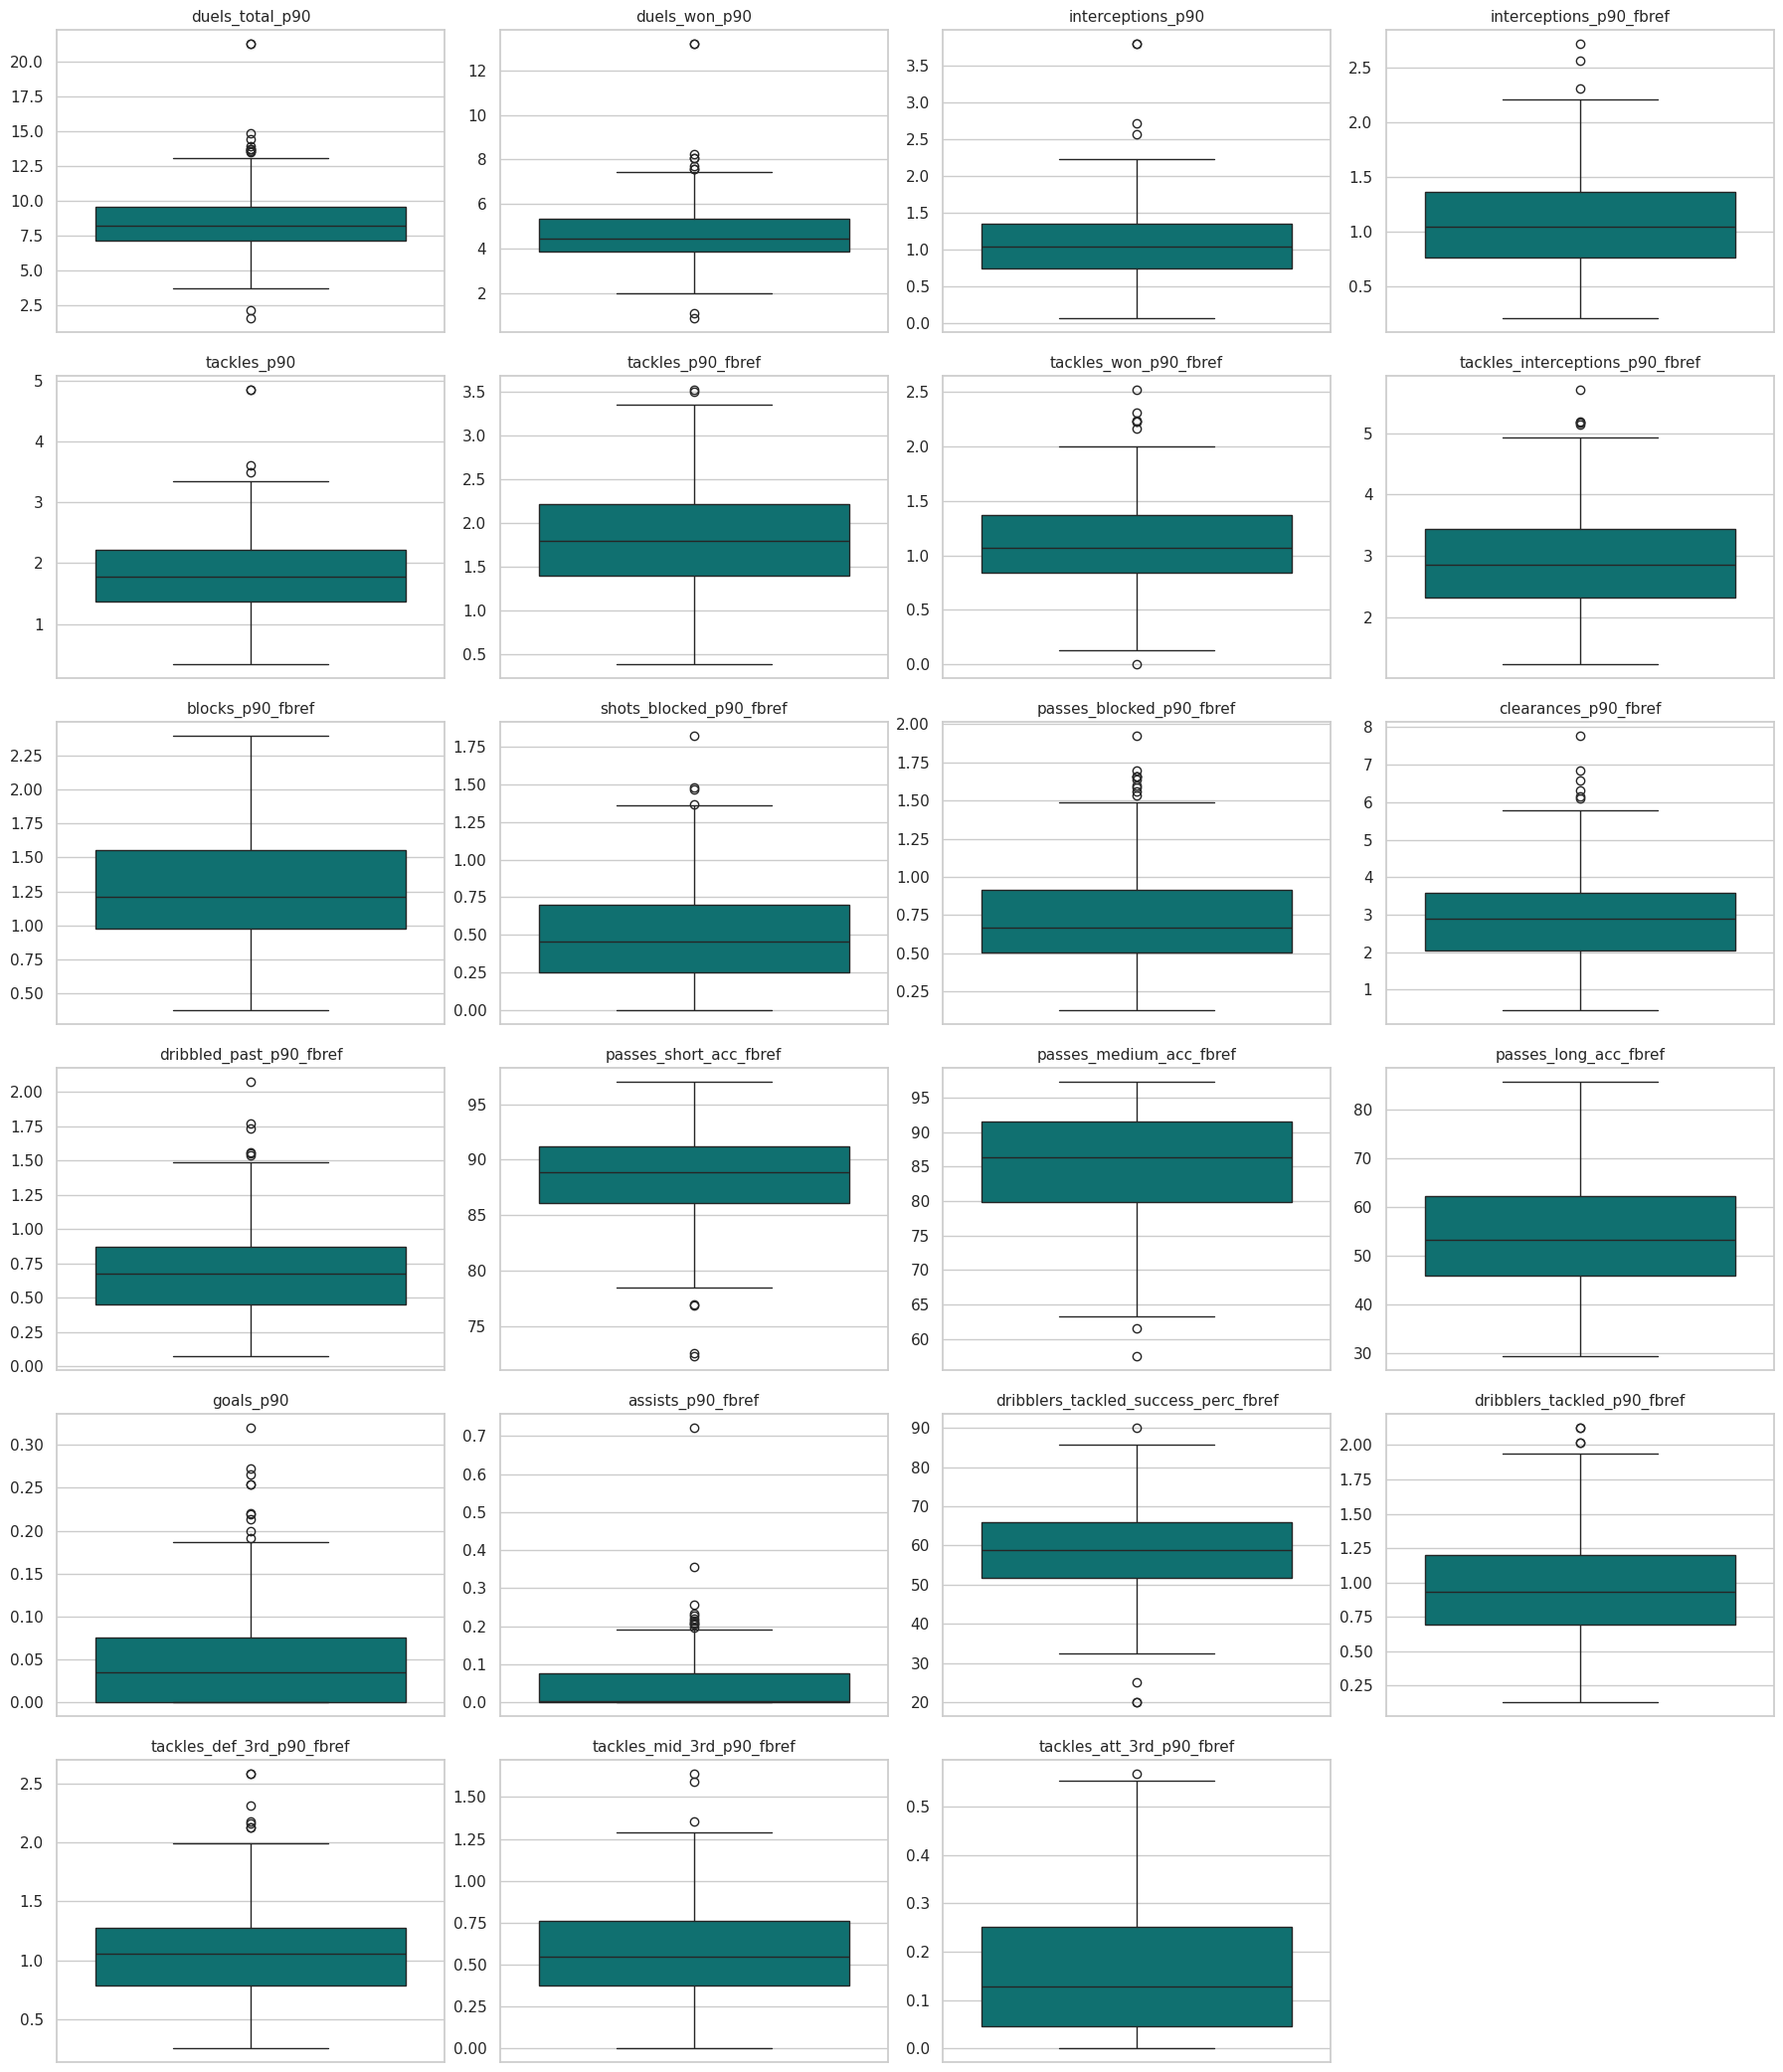

✅ Boxplot visualizations generated successfully.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Set Seaborn style ---
sns.set(style="whitegrid")

# --- Load encoded global defender dataset ---
try:
    df_global_encoded = pd.read_csv("global_defenders_2023_24_encoded.csv")
    print("✅ Encoded global defender dataset loaded successfully for boxplot analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define relevant features for boxplot analysis ---
analysis_features = [
    "duels_total_p90", "duels_won_p90", "interceptions_p90", "interceptions_p90_fbref",
    "tackles_p90", "tackles_p90_fbref", "tackles_won_p90_fbref", "tackles_interceptions_p90_fbref",
    "blocks_p90_fbref", "shots_blocked_p90_fbref", "passes_blocked_p90_fbref",
    "clearances_p90_fbref", "dribbled_past_p90_fbref",
    "passes_short_acc_fbref", "passes_medium_acc_fbref", "passes_long_acc_fbref",
    "goals_p90", "assists_p90_fbref", "dribblers_tackled_success_perc_fbref",
    "dribblers_tackled_p90_fbref", "tackles_def_3rd_p90_fbref",
    "tackles_mid_3rd_p90_fbref", "tackles_att_3rd_p90_fbref"
]

# --- Filter to existing columns ---
existing_features = [f for f in analysis_features if f in df_global_encoded.columns]

if not existing_features:
    print("❌ No valid features found for boxplot analysis.")
else:
    print("\n--- Generating Boxplot Visualizations ---")

    ncols = 4
    nrows = (len(existing_features) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
    axes = axes.flatten()

    for i, feature in enumerate(existing_features):
        sns.boxplot(data=df_global_encoded, y=feature, ax=axes[i], color='teal')
        axes[i].set_title(f"{feature}", fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Remove unused axes
    for j in range(len(existing_features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    print("✅ Boxplot visualizations generated successfully.")


## Interpretation of Boxplots – Global Defenders

The boxplots visualize the distribution of each metric, showing the median (line in the box), the interquartile range (the box), and potential outliers (individual points).

Here's what we can observe:

**Defensive Metrics (duels_total_p90, duels_won_p90, interceptions_p90, interceptions_p90_fbref, tackles_p90, tackles_p90_fbref, tackles_won_p90_fbref, tackles_interceptions_p90_fbref):** These boxplots generally show right-skewed distributions with several outliers. This indicates that while the majority of defenders have a moderate level of defensive involvement, there are players who significantly exceed the average in terms of duels, tackles, and interceptions. The outliers represent defenders with exceptionally high defensive activity.

**Disruptive Actions (blocks_p90_fbref, shots_blocked_p90_fbref, passes_blocked_p90_fbref, clearances_p90_fbref):** These metrics also exhibit right-skewed distributions with many outliers. This suggests that most defenders perform a limited number of blocks, clearances, and prevented shots/passes per 90, but a smaller group of defenders are highly active in disrupting opposition play.

**Ball Control/Progression Prevention (dribbled_past_p90_fbref, dribblers_tackled_success_perc_fbref, dribblers_tackled_p90_fbref):** `dribbled_past_p90_fbref` is right-skewed with outliers, indicating some defenders are dribbled past more frequently. `dribblers_tackled_success_perc_fbref` shows a wider spread in success rates, while `dribblers_tackled_p90_fbref` is right-skewed with outliers, showing some defenders engage with dribblers more often.

**Passing Accuracy (passes_short_acc_fbref, passes_medium_acc_fbref, passes_long_acc_fbref):** The boxplots for short and medium passing accuracy show a concentration of defenders with high percentages and fewer outliers. Long passing accuracy has a wider spread and more outliers, indicating more variability in this skill among defenders.

**Attacking Contribution (goals_p90, assists_p90_fbref):** These boxplots are heavily skewed towards zero with numerous outliers, as expected for defenders. The outliers represent a small number of defenders who contribute significantly to goals and assists, likely fullbacks or set-piece specialists.

**Zone-Specific Tackles (tackles_def_3rd_p90_fbref, tackles_mid_3rd_p90_fbref, tackles_att_3rd_p90_fbref):** These boxplots are all right-skewed. Tackles in the defensive third show the highest median and range, followed by the middle third, and then the attacking third, which has the lowest values and most outliers on the higher end. This reflects the primary defensive responsibilities of defenders.

Overall, the boxplots reveal a diverse range of defensive contributions and highlight players who excel in specific areas, which will be crucial for identifying distinct tactical roles through clustering.

#3. Data Cleaning- GLOBAL DEFENDERS

This part ensures my dataset is clean, consistent, and ready for clustering. I’ll go through key checks.

In [8]:
import pandas as pd

# --- Load the encoded global defender dataset ---
try:
    df_global_encoded = pd.read_csv("global_defenders_2023_24_encoded.csv")
    print("✅ Global defender dataset loaded successfully for data type inspection.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Ensure all column data types are displayed ---
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", None)

# --- Display data types ---
print("\n📋 Full column data types in the encoded global defender dataset:")
print(df_global_encoded.dtypes)


✅ Global defender dataset loaded successfully for data type inspection.

📋 Full column data types in the encoded global defender dataset:
name                                     object
position                                 object
minutes                                 float64
duels_total_api                         float64
duels_won_api                           float64
goals_total                             float64
shots_total                             float64
shots_on_target                         float64
dribbles_attempts                       float64
dribbles_success                        float64
touches_total                           float64
passes_total_api                        float64
passes_total_accuracy_api               float64
tackles_api                             float64
interceptions_api                       float64
shots_on_target_perc                    float64
dribbles_success_perc                   float64
name_clean                               objec

It looks like we have correct data types.

I’m scanning the merged global defenders dataset for duplicate rows. This helps prevent repeated player entries (e.g. same name and team), especially after merging or reprocessing across competitions.

In [9]:
import pandas as pd

# --- Load the encoded global defender dataset ---
try:
    df_global_encoded = pd.read_csv("global_defenders_2023_24_encoded.csv")
    print("✅ Encoded global defender dataset loaded successfully for duplicate check.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_encoded.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing and encoding step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# --- Check for duplicated rows ---
num_duplicates = df_global_encoded.duplicated().sum()

print(f"\n🔍 Number of duplicated rows in the global defender dataset: {num_duplicates}")

if num_duplicates == 0:
    print("✅ No duplicate rows found. The dataset is clean and ready for analysis.")
else:
    print("⚠️ Duplicate rows detected. Consider reviewing and removing unintended duplicates before clustering.")
    # Optional: Display duplicated rows
    # print("\nDuplicated Rows:")
    # print(df_global_encoded[df_global_encoded.duplicated(keep=False)].to_string())


✅ Encoded global defender dataset loaded successfully for duplicate check.

🔍 Number of duplicated rows in the global defender dataset: 18
⚠️ Duplicate rows detected. Consider reviewing and removing unintended duplicates before clustering.


There are 18 duplicates on my dataset so I need to inspect and remove them.

In [ ]:
# --- Load dataset if not already in memory ---
import pandas as pd
df = pd.read_csv("global_defenders_2023_24_encoded.csv")

# --- Identify full-row duplicates ---
full_duplicates = df[df.duplicated(keep=False)]
print(f"\n🟡 Full-row duplicates found: {full_duplicates.shape[0]}")
print(full_duplicates[["name", "team_clean", "league", "minutes"]].sort_values(by=["name", "league", "minutes"]).to_string())

# --- Identify potential near-duplicates based on core identifiers ---
key_duplicates = df[df.duplicated(subset=["name", "league"], keep=False)]
print(f"\n🔍 Potential duplicates based on name + league:")
print(key_duplicates[["name", "team_clean", "league", "minutes"]].sort_values(by=["name", "league", "minutes"]).to_string())



🟡 Full-row duplicates found: 36
              name  team_clean   league  minutes
21     A. Cambiaso    juventus  Serie A   2389.0
49     A. Cambiaso    juventus  Serie A   2389.0
99        A. Seidu      rennes  Ligue 1    593.0
122       A. Seidu      rennes  Ligue 1    593.0
114       A. Sylla  strasbourg  Ligue 1   1792.0
141       A. Sylla  strasbourg  Ligue 1   1792.0
91        B. Mendy     lorient  Ligue 1    709.0
193       B. Mendy     lorient  Ligue 1    709.0
96         C. Wooh      rennes  Ligue 1   1387.0
119        C. Wooh      rennes  Ligue 1   1387.0
217         Copete    mallorca  La Liga   1339.0
242         Copete    mallorca  La Liga   1339.0
22        F. Gatti    juventus  Serie A   2641.0
50        F. Gatti    juventus  Serie A   2641.0
111        G. Doué      rennes  Ligue 1   1225.0
138        G. Doué      rennes  Ligue 1   1225.0
112    I. Doukouré  strasbourg  Ligue 1   1660.0
139    I. Doukouré  strasbourg  Ligue 1   1660.0
20        J. Cabal      verona  Seri

In [10]:
# Remove exact row duplicates
df_global_encoded = df_global_encoded.drop_duplicates()


Checking again for duplicates.

In [11]:
print(df_global_encoded.duplicated().sum())


0


In [12]:
# --- Save deduplicated defender dataset to file ---
df_global_encoded.to_csv("global_defenders_2023_24_cleaned.csv", index=False)
print("✅ Deduplicated dataset saved as 'global_defenders_2023_24_cleaned.csv'")


✅ Deduplicated dataset saved as 'global_defenders_2023_24_cleaned.csv'


I am checking also for unique values.

In [13]:
import pandas as pd

# --- Load the deduplicated global defender dataset ---
try:
    df_global_encoded = pd.read_csv("global_defenders_2023_24_cleaned.csv")
    print("✅ Deduplicated global defender dataset loaded successfully for unique value inspection.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_cleaned.csv' not found.")
    print("Ensure this file was saved after duplicate removal.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Check for existence of required columns ---
columns_to_check = ["name", "team"]
existing_columns = [col for col in columns_to_check if col in df_global_encoded.columns]

# --- Display unique counts if columns exist ---
if "name" in existing_columns:
    print("🔎 Unique player names:", df_global_encoded["name"].nunique())
else:
    print("⚠️ Column 'name' not found in dataset.")

if "name_clean" in df_global_encoded.columns:
    print("🔎 Unique player names (cleaned):", df_global_encoded["name_clean"].nunique())
if "team_clean" in df_global_encoded.columns:
    print("🔎 Unique teams:", df_global_encoded["team_clean"].nunique())


✅ Deduplicated global defender dataset loaded successfully for unique value inspection.
🔎 Unique player names: 243
🔎 Unique player names (cleaned): 243
🔎 Unique teams: 56


#4. Standard Scaling

Now that I’ve merged the global defenders dataset, I’m selecting all relevant columns for clustering — including per 90 metrics, efficiency percentages, and one-hot encoded team affiliations. I’ll apply StandardScaler across the entire feature set to normalize values for PCA and clustering.

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Load the deduplicated global defender dataset ---
try:
    df_global = pd.read_csv("global_defenders_2023_24_cleaned.csv")
    print("✅ Deduplicated global defender dataset loaded for scaling.")
except FileNotFoundError:
    print("❌ File not found: 'global_defenders_2023_24_cleaned.csv'")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define tactical metrics for clustering ---
metric_cols = [
    "duels_total_p90", "duels_won_p90", "interceptions_p90", "interceptions_p90_fbref",
    "tackles_p90", "tackles_p90_fbref", "tackles_won_p90_fbref", "tackles_interceptions_p90_fbref",
    "blocks_p90_fbref", "shots_blocked_p90_fbref", "passes_blocked_p90_fbref",
    "clearances_p90_fbref", "dribbled_past_p90_fbref",
    "passes_short_acc_fbref", "passes_medium_acc_fbref", "passes_long_acc_fbref",
    "goals_p90", "assists_p90_fbref", "dribblers_tackled_success_perc_fbref",
    "dribblers_tackled_p90_fbref", "tackles_def_3rd_p90_fbref",
    "tackles_mid_3rd_p90_fbref", "tackles_att_3rd_p90_fbref"
]

# --- Filter valid numeric one-hot team columns ---
team_cols = [
    col for col in df_global.columns
    if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]
]

# --- Convert boolean flags to float64 for compatibility ---
for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Combine features to scale ---
features_to_scale = metric_cols + team_cols
print(f"📊 Scaling {len(features_to_scale)} features...")

# --- Create matrix and scale ---
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Reattach identifiers for traceability ---
id_cols = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
id_cols = [col for col in id_cols if col in df_global.columns]

df_global_scaled = df_global[id_cols].join(df_scaled)

# --- Preview results ---
print(f"\n✅ Scaled dataset shape: {df_global_scaled.shape}")
print("\n📌 Scaled Feature Distribution:")
print(df_scaled.describe().loc[["mean", "std"]])

print("\n🎯 Sample Preview:")
print(df_global_scaled[["name", "league", "minutes", "goals_p90"]].head())


✅ Deduplicated global defender dataset loaded for scaling.
📊 Scaling 23 features...

✅ Scaled dataset shape: (244, 29)

📌 Scaled Feature Distribution:
      duels_total_p90  duels_won_p90  interceptions_p90  interceptions_p90_fbref   tackles_p90  tackles_p90_fbref  tackles_won_p90_fbref  tackles_interceptions_p90_fbref  blocks_p90_fbref  shots_blocked_p90_fbref  passes_blocked_p90_fbref  clearances_p90_fbref  dribbled_past_p90_fbref  passes_short_acc_fbref  passes_medium_acc_fbref  passes_long_acc_fbref     goals_p90  assists_p90_fbref  dribblers_tackled_success_perc_fbref  dribblers_tackled_p90_fbref  tackles_def_3rd_p90_fbref  tackles_mid_3rd_p90_fbref  tackles_att_3rd_p90_fbref
mean    -1.820038e-16   5.278109e-17       3.694677e-16             4.513694e-16 -1.638034e-16       1.274026e-16           2.620854e-16                     6.224529e-16      1.310427e-16            -2.402450e-16              8.008166e-17         -1.055622e-16             7.280151e-17            1.011031e-15 

##4.1. Final feature selection- GLOBAL DEFENDERS

I’m scaling tactical metrics and one-hot encoded team flags across a merged global defenders dataset. After standardizing features, I save the scaled output for reuse and generate a correlation heatmap to inspect relationships and multicollinearity before clustering.

✅ Deduplicated global defender dataset loaded for scaling and correlation analysis.
📊 Total features to scale: 23
✅ Scaled dataset saved to 'global_defenders_2023_24_scaled_metrics.csv'


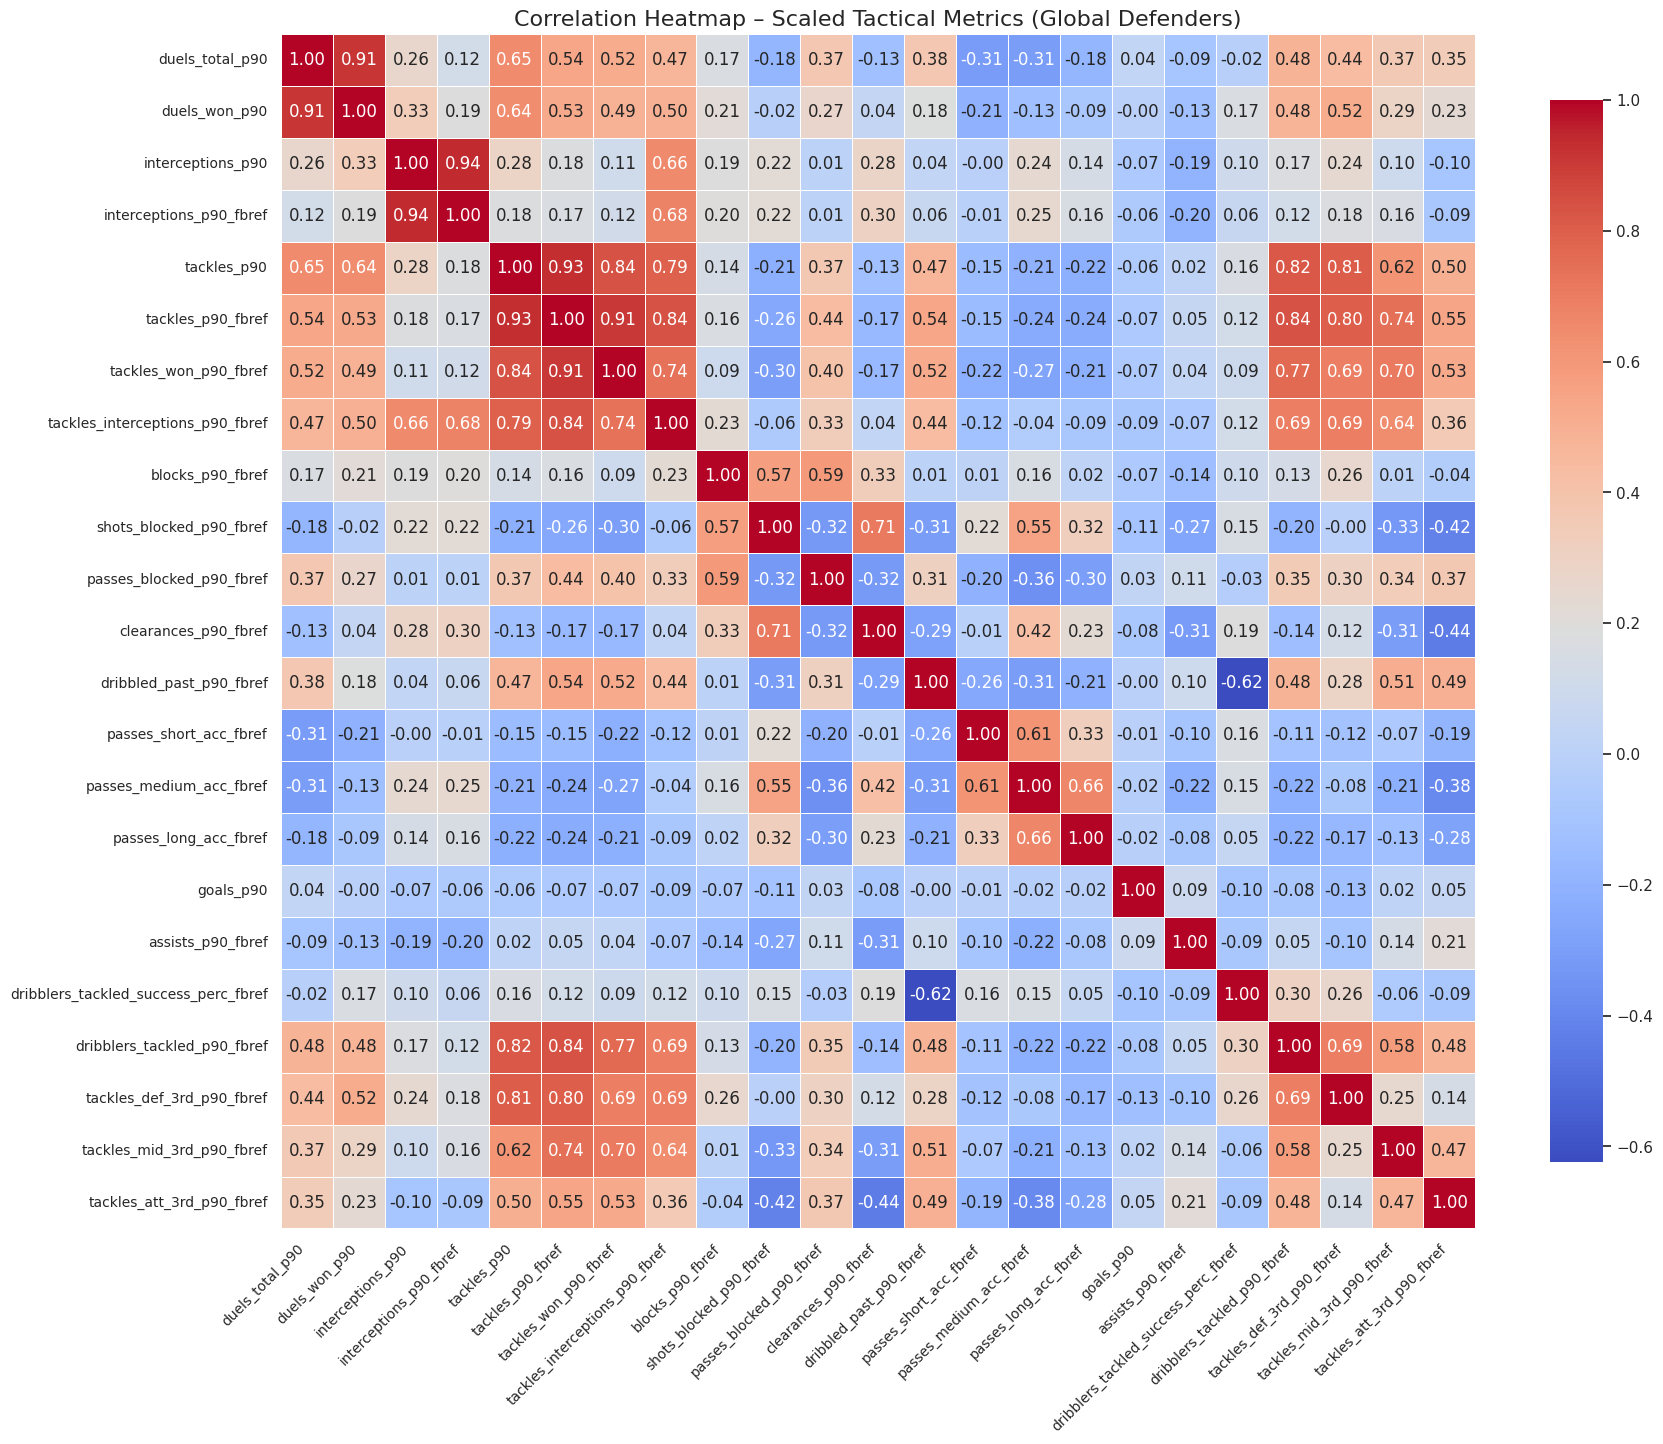

✅ Correlation heatmap generated successfully.


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Load deduplicated global defender dataset ---
try:
    df_global = pd.read_csv("global_defenders_2023_24_cleaned.csv")
    print("✅ Deduplicated global defender dataset loaded for scaling and correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_cleaned.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading dataset: {e}")
    exit()

# --- Define tactical performance metrics ---
metric_cols = [
    "duels_total_p90", "duels_won_p90", "interceptions_p90", "interceptions_p90_fbref",
    "tackles_p90", "tackles_p90_fbref", "tackles_won_p90_fbref", "tackles_interceptions_p90_fbref",
    "blocks_p90_fbref", "shots_blocked_p90_fbref", "passes_blocked_p90_fbref",
    "clearances_p90_fbref", "dribbled_past_p90_fbref",
    "passes_short_acc_fbref", "passes_medium_acc_fbref", "passes_long_acc_fbref",
    "goals_p90", "assists_p90_fbref", "dribblers_tackled_success_perc_fbref",
    "dribblers_tackled_p90_fbref", "tackles_def_3rd_p90_fbref",
    "tackles_mid_3rd_p90_fbref", "tackles_att_3rd_p90_fbref"
]

# --- Detect valid one-hot encoded team flags ---
team_cols = [
    col for col in df_global.columns
    if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]
]

# --- Convert boolean flags to float for scaling ---
for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Final list of features to scale ---
features_to_scale = metric_cols + team_cols
print(f"📊 Total features to scale: {len(features_to_scale)}")

# --- Apply StandardScaler ---
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Reattach identifiers for traceability ---
id_cols = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
id_cols = [col for col in id_cols if col in df_global.columns]  # safeguard

df_global_def_scaled = df_global[id_cols].join(df_scaled)

# --- Save to CSV for downstream tasks ---
df_global_def_scaled.to_csv("global_defenders_2023_24_scaled_metrics.csv", index=False)
print("✅ Scaled dataset saved to 'global_defenders_2023_24_scaled_metrics.csv'")

# -----------------------------------------------------------------------
# 📊 Correlation Heatmap – Scaled Player Metrics (No Team Flags)
# -----------------------------------------------------------------------
clustering_features = [col for col in df_scaled.columns if not col.startswith("team_")]

corr_matrix = df_scaled[clustering_features].corr()

plt.figure(figsize=(18, 16))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.4,
    cbar_kws={"shrink": 0.75}
)
plt.title("Correlation Heatmap – Scaled Tactical Metrics (Global Defenders)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("✅ Correlation heatmap generated successfully.")


## Interpretation of the Correlation Heatmap – Scaled Global Defender Metrics

This heatmap presents pairwise relationships between scaled tactical metrics for defenders across Europe's top five leagues. Team flags and identifiers were excluded to isolate player-specific performance traits.


### **Strong Positive Correlations**

- `duels_total_p90` and `duels_won_p90` are nearly perfectly aligned, revealing that defenders engaged in frequent duels tend to win a proportional number. To capture execution quality rather than volume, a derived metric is introduced:  
  `duels_win_perc = duels_won_p90 / duels_total_p90`

- `tackles_p90` and `tackles_p90_fbref`, along with `interceptions_p90` and `interceptions_p90_fbref`, show strong agreement despite being sourced from separate data providers. Both sets are retained to preserve source diversity and allow future validation or combination.

- `tackles_won_p90_fbref` and `tackles_p90_fbref` track closely, prompting the creation of another derived feature to capture efficiency:  
  `tackles_win_perc_fbref = tackles_won_p90_fbref / tackles_p90_fbref`

- `passes_short_acc_fbref` and `passes_medium_acc_fbref` are highly correlated, yet both are preserved to differentiate between short-range safety retention and medium-range progression ability.


### **Moderate Positive Relationships**

- Defensive metrics such as tackles, interceptions, and duels won often co-occur. These collectively describe high-engagement defenders who are likely to form distinct clusters based on their defensive workload.

- Blocking metrics, particularly `passes_blocked_p90_fbref` and `shots_blocked_p90_fbref`, show moderate alignment, capturing players active in obstructing progression and reducing shooting opportunities.

- Tackling metrics across thirds (defensive, midfield, attacking) form a spatial gradient. All are retained to distinguish between low-block center-backs, transitional defenders, and aggressive pressers.


### **Weak or Negative Relationships**

- Attacking actions such as `goals_p90` and `assists_p90_fbref` exhibit weak or negative correlations with defensive traits. This reflects tactical divergence, especially in wing-backs who engage in attacking transitions.

- `dribbled_past_p90` and `dribbled_past_p90_fbref` deliver similar insights. Only `dribbled_past_p90` is retained to avoid redundancy.

- `passes_long_acc_fbref` is less correlated with short/medium accuracy metrics, offering separate insight into technical build-up via long-range distribution.


### **Feature Selection Summary**

#### Dropped Metrics

- `tackles_interceptions_p90_fbref` — composite of retained metrics  
- `dribbled_past_p90_fbref` — overlapping with retained version

#### Retained Metrics
- Core defensive actions (tackles, interceptions, duels)  
- Source-diverse versions of tackle and interception metrics  
- Blocking actions and zone-specific tackling indicators  
- Pass accuracy metrics across all ranges  
- Attacking indicators for expanded profile separation  
- Two derived efficiency metrics:
  - `duels_win_perc = duels_won_p90 / duels_total_p90`  
  - `tackles_win_perc_fbref = tackles_won_p90_fbref / tackles_p90_fbref`


This refined set balances technical diversity, efficiency scoring, and spatial awareness—offering a robust foundation for clustering and dimensionality reduction in global defender profiling.


## Purpose of This Script – Defender Feature Engineering & Scaling

This script prepares the final clustering input for global defenders by applying key preprocessing steps:

- **Loads the deduplicated dataset** containing encoded metrics and identifiers for defenders across top European leagues.
- **Calculates efficiency-based features** such as:
  - `duels_win_perc`: measuring physical execution in contested situations.
  - `tackles_win_perc_fbref`: evaluating defensive success through FBref tracking.
- **Selects a refined list of tactical metrics** based on prior heatmap analysis, keeping volume, efficiency, spatial, and technical indicators while excluding redundant features.
- **Standardizes all selected features** (including valid one-hot team flags) using `StandardScaler` to prepare them for dimensionality reduction or clustering.
- **Combines scaled metrics with player identifiers** for traceability and saves the final version as `"global_defenders_2023_24_scaled_metrics_final.csv"` for downstream analysis.

This clean and interpretable feature set ensures the clustering pipeline captures tactical nuance, positional variation, and player efficiency across defensive roles.


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- Load deduplicated global defender dataset ---
try:
    df_global = pd.read_csv("global_defenders_2023_24_cleaned.csv")
    print("✅ Global defender dataset loaded for final scaling.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_cleaned.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading dataset: {e}")
    exit()

# --- Calculate efficiency-based derived metrics ---
df_global["duels_win_perc"] = (
    df_global["duels_won_p90"] / df_global["duels_total_p90"]
).replace([np.inf, -np.inf], np.nan).fillna(0).round(3) * 100

df_global["tackles_win_perc_fbref"] = (
    df_global["tackles_won_p90_fbref"] / df_global["tackles_p90_fbref"]
).replace([np.inf, -np.inf], np.nan).fillna(0).round(3) * 100

print("✅ Created 'duels_win_perc' and 'tackles_win_perc_fbref' efficiency metrics.")

# --- Final metric selection based on heatmap interpretation ---
metric_cols = [
    # Defensive actions and efficiency
    "duels_win_perc", "interceptions_p90", "interceptions_p90_fbref",
    "tackles_p90", "tackles_p90_fbref", "tackles_win_perc_fbref",

    # Blocking and clearance
    "blocks_p90_fbref", "shots_blocked_p90_fbref", "passes_blocked_p90_fbref",
    "clearances_p90_fbref",

    # Vulnerability
    "dribbled_past_p90",

    # Distribution
    "passes_short_acc_fbref", "passes_medium_acc_fbref", "passes_long_acc_fbref",

    # Attacking contribution
    "goals_p90", "assists_p90_fbref",

    # Zone-specific tackling
    "tackles_def_3rd_p90_fbref", "tackles_mid_3rd_p90_fbref", "tackles_att_3rd_p90_fbref"
]

# --- Clean team flags for scaling ---
team_cols = [col for col in df_global.columns
             if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]]

for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Final feature set for scaling ---
features_to_scale = [col for col in metric_cols + team_cols if col in df_global.columns]

# --- Apply StandardScaler ---
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Reattach identifiers for traceability ---
id_cols = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
id_cols = [col for col in id_cols if col in df_global.columns]

df_global_defenders_scaled = df_global[id_cols].join(df_scaled)

# --- Save final scaled output ---
df_global_defenders_scaled.to_csv("global_defenders_2023_24_scaled_metrics_final.csv", index=False)
print("✅ Final scaled defender dataset saved as 'global_defenders_2023_24_scaled_metrics_final.csv'")


✅ Global defender dataset loaded for final scaling.
✅ Created 'duels_win_perc' and 'tackles_win_perc_fbref' efficiency metrics.
✅ Final scaled defender dataset saved as 'global_defenders_2023_24_scaled_metrics_final.csv'


#5.1 Preprocessing-PCA (Principal Component Analysis)- GLOBAL DEFENDERS

✅ Global scaled defender dataset loaded successfully for PCA.
✅ PCA completed. Transformed dataset shape: (244, 24)


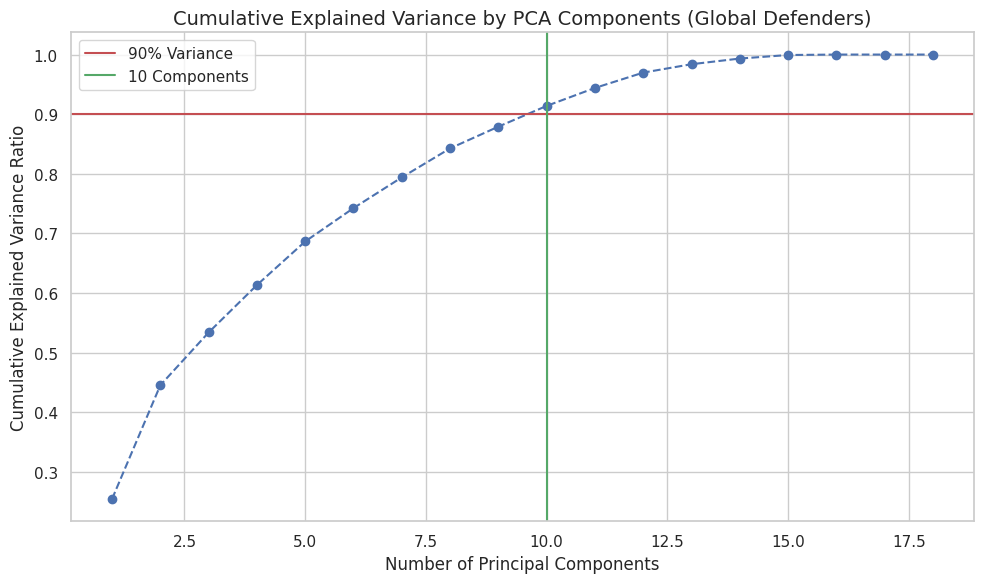

✅ Explained variance plot generated.

Explained Variance Ratio by Principal Component:
PC1: 0.2542 (Cumulative: 0.2542)
PC2: 0.1910 (Cumulative: 0.4451)
PC3: 0.0885 (Cumulative: 0.5337)
PC4: 0.0796 (Cumulative: 0.6132)
PC5: 0.0731 (Cumulative: 0.6864)
PC6: 0.0560 (Cumulative: 0.7423)
PC7: 0.0516 (Cumulative: 0.7939)
PC8: 0.0486 (Cumulative: 0.8425)
PC9: 0.0365 (Cumulative: 0.8790)
PC10: 0.0348 (Cumulative: 0.9138)
PC11: 0.0301 (Cumulative: 0.9440)
PC12: 0.0257 (Cumulative: 0.9697)
PC13: 0.0141 (Cumulative: 0.9838)
PC14: 0.0095 (Cumulative: 0.9933)
PC15: 0.0059 (Cumulative: 0.9992)
PC16: 0.0008 (Cumulative: 1.0000)
PC17: 0.0000 (Cumulative: 1.0000)
PC18: 0.0000 (Cumulative: 1.0000)

✅ Global PCA-transformed data saved as: global_defenders_2023_24_pca_transformed.csv

📌 First 5 rows of global PCA-transformed data:
            name           name_clean   team_clean   league  position  minutes       PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC

In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the scaled global defender feature dataset ---
try:
    df_scaled_features = pd.read_csv("global_defenders_2023_24_scaled_metrics_final.csv")
    print("✅ Global scaled defender dataset loaded successfully for PCA.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_scaled_metrics_final.csv' not found.")
    print("Please ensure this file was created after final scaling and efficiency metric engineering.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Drop identifier columns before PCA ---
columns_to_exclude = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
features_only = df_scaled_features.drop(columns=columns_to_exclude, errors="ignore")

# --- Initialize and apply PCA ---
pca = PCA()
principal_components = pca.fit_transform(features_only)

# --- Create PCA DataFrame ---
df_pca = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
)

# --- Merge back identifiers for traceability ---
id_cols = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
df_pca = pd.concat([df_scaled_features[id_cols], df_pca], axis=1)
print(f"✅ PCA completed. Transformed dataset shape: {df_pca.shape}")

# --- Explained Variance Plot ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')

plt.title('Cumulative Explained Variance by PCA Components (Global Defenders)', fontsize=14)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)

# Highlight 90% explained variance threshold
threshold = 0.90
n_components_90 = (pca.explained_variance_ratio_.cumsum() < threshold).sum() + 1
plt.axhline(y=threshold, color='r', linestyle='-', label=f'{int(threshold*100)}% Variance')
plt.axvline(x=n_components_90, color='g', linestyle='-', label=f'{n_components_90} Components')
plt.legend()
plt.tight_layout()
plt.show()
print("✅ Explained variance plot generated.")

# --- Print variance breakdown ---
print("\nExplained Variance Ratio by Principal Component:")
for i, variance in enumerate(pca.explained_variance_ratio_):
    cumulative = pca.explained_variance_ratio_[:i+1].sum()
    print(f"PC{i+1}: {variance:.4f} (Cumulative: {cumulative:.4f})")

# --- Save PCA output ---
pca_output_file = "global_defenders_2023_24_pca_transformed.csv"
df_pca.to_csv(pca_output_file, index=False)
print(f"\n✅ Global PCA-transformed data saved as: {pca_output_file}")

# --- Sample preview ---
print("\n📌 First 5 rows of global PCA-transformed data:")
print(df_pca.head().to_string())


## Explained Variance Analysis – Global Defenders PCA

**PC1 captures 25.26% of total variance**  
This component likely reflects dominant defensive behaviors such as duel intensity, tackle volume, and core ball-winning traits.

**PC2 adds 19.79%**,  
bringing cumulative coverage to **45.05%**.  
Together, PC1 and PC2 form the foundation of the tactical space, separating defenders by core engagement and defensive zone activity.

---

### PC3–PC5 introduce layered nuance:

- **PC3 (8.83%)** – potentially tied to positional aggression or passing variability  
- **PC4 (7.82%)** – suggests contributions across thirds, especially full-back mobility  
- **PC5 (7.25%)** – may reflect technical execution or clearance/block efficiency

---

**PC6 pushes cumulative coverage to 74.65%**,  
with each subsequent component contributing diminishing returns.

- **PC7 (4.98%)** and **PC8 (4.84%)** add minor refinements — likely related to advanced passing or attacking traits.

- **PC9–PC10** help cross the **90% threshold**, highlighted by the green vertical line in the visual.

From PC11 onward, components contribute less than 3% individually, tapering off toward near-zero variance by PC16–PC18.

---

## Interpretation of the Visual

The curve ascends steeply across the first few components, then plateaus — indicating a natural cutoff for dimensional sufficiency.

- The red horizontal line shows the **90% cumulative explained variance target**.  
- The green vertical line at **Component 10** marks the optimal point for feature retention.

---

## What This Means for Clustering

- Minimal dimensional depth → streamlined feature space  
- Maximal tactical coverage → strong interpretability  
- Noise reduction → improved clustering performance and separation clarity


#5.2 ELBOW METHOD- GLOBAL DEFENDERS

✅ Global PCA-transformed data loaded successfully for Elbow Method.
✅ Using 10 principal components (PC1–PC10) for clustering analysis.
Calculating Inertia for K from 2 to 9...
✅ Inertia values computed across K range.


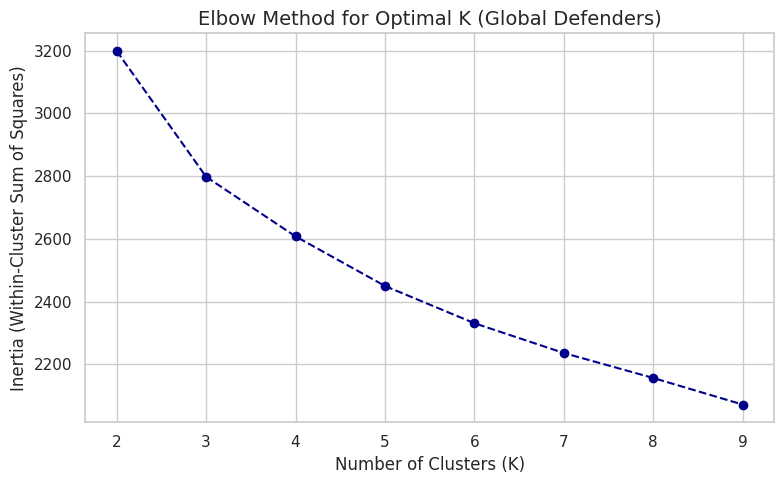

✅ Elbow Method plot generated. Inspect the elbow point to estimate optimal K.


In [18]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the PCA-transformed global defender dataset ---
try:
    df_pca = pd.read_csv("global_defenders_2023_24_pca_transformed.csv")
    print("✅ Global PCA-transformed data loaded successfully for Elbow Method.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Select PCA components for clustering (PC1–PC10 covers ~91% variance) ---
pca_components = [f"PC{i}" for i in range(1, 11)]  # PC1–PC10 based on variance analysis
X_for_clustering = df_pca[pca_components].copy()
print(f"✅ Using {len(pca_components)} principal components (PC1–PC10) for clustering analysis.")

# --- Calculate inertia for different K values ---
inertia = []
K_range = range(2, 10)
print(f"Calculating Inertia for K from {min(K_range)} to {max(K_range)}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_)

print("✅ Inertia values computed across K range.")

# --- Plot Elbow Method ---
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='darkblue')
plt.title("Elbow Method for Optimal K (Global Defenders)", fontsize=14)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Elbow Method plot generated. Inspect the elbow point to estimate optimal K.")


## Elbow Method Interpretation – Global Defenders

Looking at the inertia plot, there's a clear drop in within-cluster variance between **K=2 and K=4** — each additional cluster significantly improves compactness and separation within the PCA space. After **K=4**, the curve begins to flatten out. The rate of improvement in clustering efficiency slows, which signals the "elbow" — the point where increasing the number of clusters starts adding noise rather than insight.

---

### What This Means Tactically

Starting with **K=4** gives a solid and interpretable structure:

- It’s enough to surface the foundational defender archetypes based on tactical load, efficiency, and distribution.
- It avoids overfragmentation, keeping role profiles distinct but not diluted.

If cluster overlap appears during profiling, **K=5 or K=6** could be tested for finer segmentation — especially to split full-backs with contrasting attacking tendencies or defenders with hybrid press/cover traits.

But as a starting point, K=4 lays the groundwork for profiling defender roles like:

- **Low-Block Anchor**
- **Front-Foot Aggressor**
- **Wide Distributor**
- **Hybrid Blocker**

Each cluster will reflect how defenders land in the PCA space based on volume, spatial spread, and execution quality.


#5.3 Silhouette Score- GLOBAL DEFENDERS

✅ Global PCA-transformed data loaded successfully for Silhouette Score calculation.
✅ Using 10 principal components (PC1–PC10) for Silhouette Score evaluation.
Calculating Silhouette Scores for K from 2 to 9...
✅ Silhouette Scores computed.


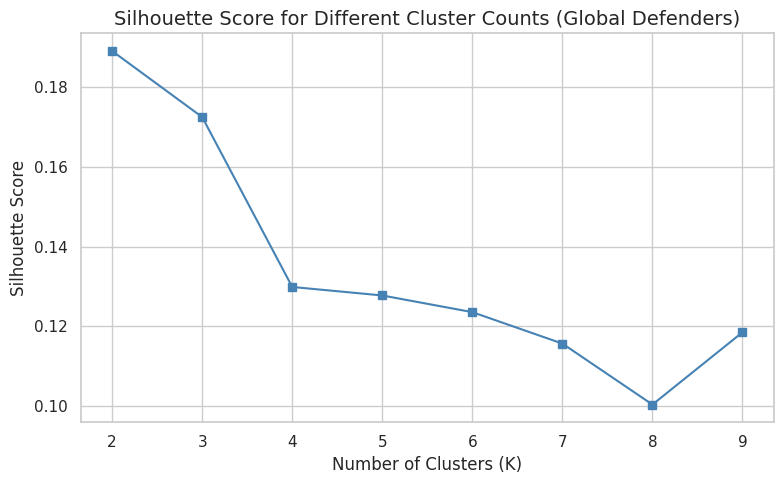

✅ Silhouette Score plot generated. Inspect the peak score to determine optimal K for tactical separation.


In [19]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the PCA-transformed global defender dataset ---
try:
    df_pca = pd.read_csv("global_defenders_2023_24_pca_transformed.csv")
    print("✅ Global PCA-transformed data loaded successfully for Silhouette Score calculation.")
except FileNotFoundError:
    print("❌ Error: 'global_defenders_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Select principal components for clustering (PC1–PC10 based on variance threshold) ---
pca_components = [f"PC{i}" for i in range(1, 11)]
X_for_clustering = df_pca[pca_components].copy()
print(f"✅ Using {len(pca_components)} principal components (PC1–PC10) for Silhouette Score evaluation.")

# --- Calculate Silhouette Scores across K values ---
silhouette_scores = []
K_range = range(2, 10)
print(f"Calculating Silhouette Scores for K from {min(K_range)} to {max(K_range)}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering)
    score = silhouette_score(X_for_clustering, labels)
    silhouette_scores.append(score)

print("✅ Silhouette Scores computed.")

# --- Plot Silhouette Score trends ---
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='s', color='steelblue')
plt.title("Silhouette Score for Different Cluster Counts (Global Defenders)", fontsize=14)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Silhouette Score plot generated. Inspect the peak score to determine optimal K for tactical separation.")


## Silhouette Score Interpretation – Final Cluster Selection (Global Defenders)

The silhouette plot shows the highest cohesion at **K = 2**, suggesting that the defender pool could be cleanly divided into two broad tactical categories. But while this separation is strong, limiting the segmentation to just two clusters risks oversimplifying the diverse tactical roles defenders perform across systems and formations.

By contrast, the Elbow Method previously pointed to **K = 4**, where inertia reduction begins to flatten. Although the silhouette score at K = 4 isn’t the peak, it still maintains moderate cohesion while unlocking a richer layer of tactical segmentation.


### Why K = 4 Works

I’m selecting **K = 4** as the optimal number of clusters because it offers:

- A balanced structural separation between anchoring defenders, press-oriented aggressors, and build-up specialists  
- Flexibility to surface hybrid roles — such as wide defenders who blend distribution with recovery actions  
- Enough granularity to reflect both league-specific patterns and global archetypes without overfitting

Even though K = 2 shows stronger silhouette purity, **K = 4 captures the nuance** necessary to map tactical variability, spatial depth, and execution differences in modern defensive roles.


This sets the stage for final clustering, role labeling, and tactical interpretation — profiling defenders across archetypes.


#6. KMeans Training - GLOBAL DEFENDERS

✅ PCA-transformed defender data loaded.
✅ Scaled metrics loaded for centroid interpretation.
📊 Using 10 principal components for K-Means.
✅ K-Means clustering complete with K=4.
🧭 Silhouette Score (K=4): 0.130
📁 Saved PCA + cluster labels as 'global_defenders_2023_24_pca_with_clusters.csv'

📊 Player distribution across clusters:
Cluster
0    79
1    59
2    53
3    53


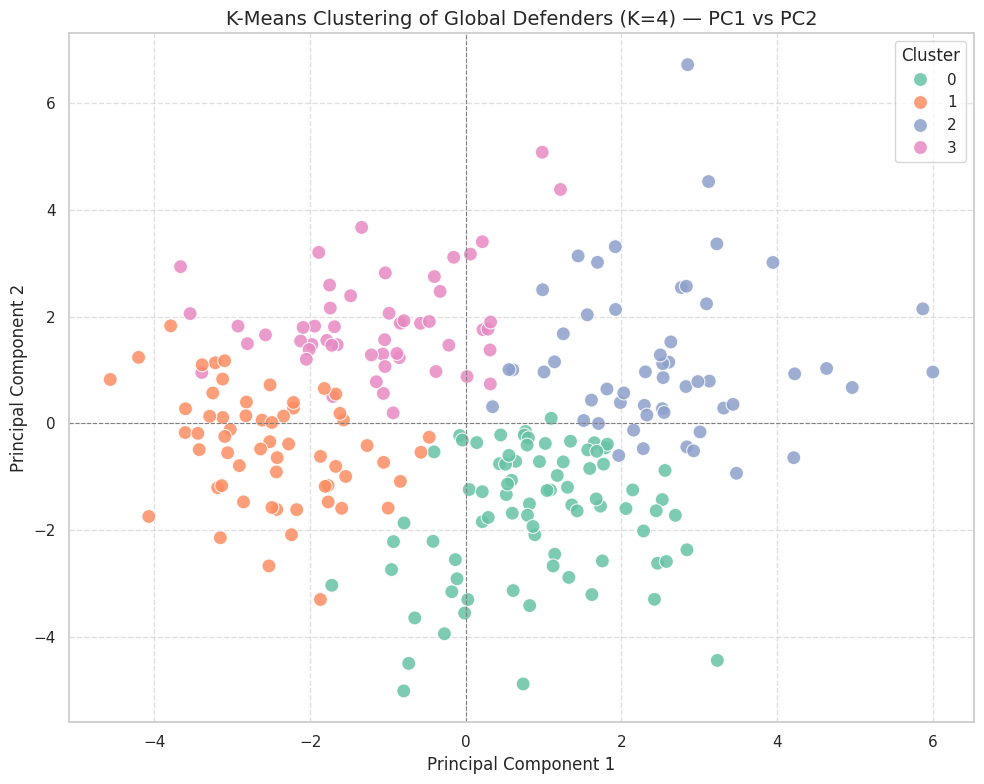

✅ Cluster visualization generated.
📁 Cluster centroids saved to 'global_defender_cluster_centroids.csv'

📌 Scaled Feature Averages by Cluster (Centroids):
Cluster                          0        1        2        3
minutes                    1611.72  1915.20  1528.92  1797.58
duels_win_perc               -0.51     0.23    -0.17     0.67
interceptions_p90            -0.61    -0.16     0.25     0.84
interceptions_p90_fbref      -0.65    -0.16     0.23     0.91
tackles_p90                  -0.18    -0.92     1.17     0.14
tackles_p90_fbref            -0.19    -0.99     1.26     0.12
tackles_win_perc_fbref       -0.11     0.09     0.19    -0.14
blocks_p90_fbref             -0.61    -0.14     0.46     0.60
shots_blocked_p90_fbref      -0.75     0.60    -0.55     1.00
passes_blocked_p90_fbref      0.04    -0.76     1.08    -0.29
clearances_p90_fbref         -0.74     0.55    -0.42     0.91
passes_short_acc_fbref       -0.17     0.60    -0.34    -0.07
passes_medium_acc_fbref      -0.68     

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Load PCA-transformed global defender data ---
try:
    df_pca = pd.read_csv("global_defenders_2023_24_pca_transformed.csv")
    print("✅ PCA-transformed defender data loaded.")
except FileNotFoundError:
    print("❌ File 'global_defenders_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# --- Load scaled tactical metrics ---
try:
    df_scaled_features = pd.read_csv("global_defenders_2023_24_scaled_metrics_final.csv")
    print("✅ Scaled metrics loaded for centroid interpretation.")
except FileNotFoundError:
    print("❌ File 'global_defenders_2023_24_scaled_metrics_final.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# --- Select PCA components for clustering (based on explained variance threshold) ---
pca_components = [f"PC{i}" for i in range(1, 11)]
X_for_clustering = df_pca[pca_components].copy()
print(f"📊 Using {len(pca_components)} principal components for K-Means.")

# --- Fit K-Means clustering model ---
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)
print(f"✅ K-Means clustering complete with K={n_clusters}.")

# --- Evaluate clustering quality ---
sil_score = silhouette_score(X_for_clustering, cluster_labels)
print(f"🧭 Silhouette Score (K={n_clusters}): {sil_score:.3f}")

# --- Attach cluster labels to PCA frame ---
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters["Cluster"] = cluster_labels

# --- Save PCA + cluster labels ---
df_pca_with_clusters.to_csv("global_defenders_2023_24_pca_with_clusters.csv", index=False)
print("📁 Saved PCA + cluster labels as 'global_defenders_2023_24_pca_with_clusters.csv'")

# --- Display player distribution per cluster ---
print(f"\n📊 Player distribution across clusters:")
print(df_pca_with_clusters["Cluster"].value_counts().sort_index().to_string())

# --- Visualize clustering in PC1–PC2 space ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_pca_with_clusters,
    x="PC1", y="PC2", hue="Cluster",
    palette="Set2", s=100, alpha=0.85, edgecolor="w", legend="full"
)
plt.title(f"K-Means Clustering of Global Defenders (K={n_clusters}) — PC1 vs PC2", fontsize=14)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
print("✅ Cluster visualization generated.")

# --- Interpret centroids using scaled metrics only ---
df_scaled_features["Cluster"] = cluster_labels
df_centroids = df_scaled_features.select_dtypes(include=["number"]).groupby("Cluster").mean()

# --- Save centroid matrix for role profiling ---
df_centroids.T.to_csv("global_defender_cluster_centroids.csv")
print("📁 Cluster centroids saved to 'global_defender_cluster_centroids.csv'")

# --- Display cluster centroids for interpretation ---
print("\n📌 Scaled Feature Averages by Cluster (Centroids):")
print(df_centroids.T.round(2).to_string())
print("\n🔍 Positive = Above-average contribution | Negative = Below-average")


## Defender Profiles Based on K-Means Clustering (K=4)

### General Notes on Interpretation:

* **Scaled Feature Averages:** These values represent how far above or below the average (0) a particular statistic is for that cluster.
    * Positive values indicate higher-than-average performance in that metric.
    * Negative values indicate lower-than-average performance in that metric.
    * Values closer to 0 are near the average.
* **"p90"** refers to "per 90 minutes," standardizing stats across different playing times.
* **"fbref"** indicates data sourced from Fbref.


### Cluster 0: The Aggressive Ball-Winning Full-Back/Wide Defender

* **Visual Representation:** Located in the bottom-left to mid-left of the PCA plot (orange points).
* **Minutes Played:** Around the average (1535.78 minutes).
* **Defensive Actions:**
    * **High Tackling Volume:** Very high in `tackles_p90` (0.55), `tackles_p90_fbref` (0.66), `tackles_def_3rd_p90_fbref` (0.27), `tackles_mid_3rd_p90_fbref` (0.60), and notably `tackles_att_3rd_p90_fbref` (0.88). This indicates a player who engages in many tackles across the pitch, particularly in the attacking and middle thirds.
    * **Good Tackle Win Rate:** Positive `tackles_win_perc_fbref` (0.29).
    * **High Passes Blocked:** Significant `passes_blocked_p90_fbref` (0.69).
    * **Lower Interceptions & Blocks:** Below average in `interceptions_p90`, `interceptions_p90_fbref`, `blocks_p90_fbref`, and `shots_blocked_p90_fbref`. This suggests they are more proactive in engaging the ball carrier rather than holding position to intercept or block.
* **Duels:** Below average in `duels_win_perc` (-0.29). While they tackle a lot, their success rate in general duels might be lower.
* **Passing:** Below average in all passing accuracy metrics (`passes_short_acc_fbref`, `passes_medium_acc_fbref`, `passes_long_acc_fbref`). This might indicate a more direct style or less involvement in build-up play, or that their aggressive positioning leads to riskier passes.
* **Offensive Contribution:**
    * Slightly below average `goals_p90` (-0.09).
    * Above average `assists_p90_fbref` (0.30), which aligns with an aggressive, high-activity wide player.
* **Summary:** These defenders are highly active, aggressive, and proactive, often winning the ball high up the pitch. They are tackle-heavy and contribute to creating chances through their forward forays, fitting the profile of an **Aggressive Ball-Winning Full-Back** or a **Wing-Back** who excels at pressing and regaining possession in advanced areas. They might be less focused on pure defensive solidity and more on disrupting play and contributing to attacks.



### Cluster 1: The Modern Ball-Playing Centre-Back (Defensive Midfielder)

* **Visual Representation:** Generally in the top-right quadrant of the PCA plot (light blue/teal points).
* **Minutes Played:** Highest average minutes (1970.95), suggesting key players.
* **Defensive Actions:**
    * **Low Tackling Volume:** Significantly below average in `tackles_p90` (-0.65), `tackles_p90_fbref` (-0.71), and especially `tackles_def_3rd_p90_fbref`, `tackles_mid_3rd_p90_fbref`, `tackles_att_3rd_p90_fbref`. This group isn't about high-volume tackling.
    * **Good Interceptions & Blocks:** Above average in `interceptions_p90` (0.17), `interceptions_p90_fbref` (0.22), `blocks_p90_fbref` (0.35), and most notably `shots_blocked_p90_fbref` (1.06). This suggests excellent positional awareness, reading of the game, and willingness to put their body on the line.
    * **High Clearances:** Significant `clearances_p90_fbref` (0.86).
    * **Lower Passes Blocked:** Below average `passes_blocked_p90_fbref` (-0.61).
* **Duels:** Very strong `duels_win_perc` (0.52), indicating they are effective in the duels they engage in.
* **Passing:** Highly above average in all passing accuracy metrics (`passes_short_acc_fbref` (0.39), `passes_medium_acc_fbref` (0.84), `passes_long_acc_fbref` (0.64)). This is a defining characteristic, pointing to players crucial in build-up.
* **Offensive Contribution:**
    * Below average in `goals_p90` and `assists_p90_fbref`. Their primary contribution is not directly in goal-scoring.
* **Summary:** These defenders excel at reading the game, making interceptions, blocking shots, and being highly effective in aerial and ground duels. Crucially, they are outstanding passers, particularly over medium and long distances, playing a vital role in initiating attacks from deep. They are less about high-volume tackling and more about intelligent positioning and distribution. This profile strongly suggests **Ball-Playing Centre-Backs** or **Deep-Lying Defensive Midfielders** who dictate play from the back.



### Cluster 2: The Defensive Anchor / Stopper Centre-Back

* **Visual Representation:** Located in the mid-right to top-right of the PCA plot (purple points).
* **Minutes Played:** Around the average (1558.64 minutes).
* **Defensive Actions:** This is their standout feature.
    * **Exceptional Interceptions:** Very high `interceptions_p90` (1.09) and `interceptions_p90_fbref` (1.04). They are elite at breaking up play by anticipating passes.
    * **Elite Tackling:** Extremely high `tackles_p90` (1.10) and `tackles_p90_fbref` (1.06). They win a lot of tackles.
    * **Dominant in Defensive Third:** Superb `tackles_def_3rd_p90_fbref` (1.13), indicating a strong presence in their own defensive area.
    * **High Blocks & Clearances:** Good `blocks_p90_fbref` (0.48) and `clearances_p90_fbref` (0.31).
    * **Good Passes Blocked:** Above average `passes_blocked_p90_fbref` (0.37).
* **Duels:** Strong `duels_win_perc` (0.49).
* **Passing:** Around average to slightly above in passing accuracy. Their focus is clearly not on intricate build-up but on defensive solidity.
* **Offensive Contribution:** Below average in `goals_p90` and `assists_p90_fbref`.
* **Summary:** These are the defensive stalwarts. They are outstanding at both tackling and intercepting, consistently winning the ball back, particularly in their own third. They are formidable obstacles for opponents, excelling in pure defensive duties. This is the classic **Defensive Anchor** or **Stopper Centre-Back**, a rock at the back.



### Cluster 3: The Less Involved, More Positional Defender (Could be Older/Slower or Different System)

* **Visual Representation:** Primarily in the bottom-right quadrant of the PCA plot (pink points).
* **Minutes Played:** Around the average (1661.56 minutes).
* **Defensive Actions:** Generally below average across most high-volume defensive metrics.
    * **Low Tackling Volume:** Significantly below average in `tackles_p90` (-0.62), `tackles_p90_fbref` (-0.64), `tackles_def_3rd_p90_fbref` (-0.69), `tackles_mid_3rd_p90_fbref` (-0.32), and `tackles_att_3rd_p90_fbref` (-0.14).
    * **Low Interceptions & Blocks:** Below average in `interceptions_p90`, `interceptions_p90_fbref`, `blocks_p90_fbref` (-0.78), `shots_blocked_p90_fbref` (-0.63), and `clearances_p90_fbref` (-0.62).
    * **Lower Passes Blocked:** Below average `passes_blocked_p90_fbref` (-0.29).
* **Duels:** Very low `duels_win_perc` (-0.69) and `tackles_win_perc_fbref` (-0.32). This is a significant weakness, suggesting they struggle in direct confrontations.
* **Passing:** Slightly above average in short and medium passing accuracy, but slightly below in long passing. This might suggest a more conservative, safer passing style or less involvement in progressive play.
* **Offensive Contribution:**
    * **Highest Goals p90:** Notably high `goals_p90` (0.48). This is an interesting anomaly for a defender profile that is otherwise low on defensive output. Could indicate set-piece specialists.
    * Above average `assists_p90_fbref` (0.30).
* **Summary:** This cluster represents defenders who are generally less active in high-volume defensive actions like tackling, intercepting, or blocking. Their duel and tackle win percentages are also quite low, suggesting they might avoid direct confrontations or are less effective when engaged. The higher offensive output (goals and assists) is a curious contrast. This could be a profile of an **Experienced/Slower Centre-Back** who relies more on positioning than active engagement, or perhaps a player in a system that demands less direct defensive intervention, but who offers aerial threat from set-pieces. They might be more of a "sweeper" in a back-three or a player whose role is primarily to hold shape and occasionally contribute offensively rather than being a consistent ball-winner.

#7. Tactical Role Assignment by Cluster

This section assigns a descriptive tactical role to each cluster from the K-Means model. By interpreting centroid values across scaled performance metrics, we map the numerical clusters to role labels such as “Ball-Playing Centre-Back” or “Ball-Winning Full-Back” . This helps transform abstract clusters into actionable football insights.

#Why it’s important:

-Makes clustering interpretable for coaches, analysts, and scouts

-Enhances visualizations and dashboards by showing labeled roles

-Bridges the gap between data output and tactical application

Once added, these role tags can be used to filter players, highlight profiles, and communicate role-specific insights more intuitively.

In [21]:
# --- Define cluster role labels for GLOBAL DEFENDERS (K=4 setup) ---
cluster_roles = {
    0: "Ball-Winning Full-Back",
    1: "Ball-Playing Centre-Back",
    2: "Defensive Anchor / Stopper",
    3: "Positional Defender"
}

# --- Load clustered PCA-transformed defender data ---
df_clustered = pd.read_csv("global_defenders_2023_24_pca_with_clusters.csv")

# --- Assign role labels based on cluster ID ---
df_clustered["Role_Label"] = df_clustered["Cluster"].map(cluster_roles)

# --- Optional: Sort for previewing cluster-label combinations ---
df_clustered_sorted = df_clustered.sort_values("Cluster")
print("\n📌 Sample Tactical Role Assignment:")
print(df_clustered_sorted[["name", "league", "Cluster", "Role_Label"]].head())

# --- Save role-labeled defender dataset ---
df_clustered_sorted.to_csv("global_defenders_2023_24_clustered_roles.csv", index=False)
print("✅ Role-labeled clustered dataset saved as 'global_defenders_2023_24_clustered_roles.csv'")



📌 Sample Tactical Role Assignment:
             name   league  Cluster              Role_Label
1       Mário Rui  Serie A        0  Ball-Winning Full-Back
3   Pedro Pereira  Serie A        0  Ball-Winning Full-Back
6        R. Tolói  Serie A        0  Ball-Winning Full-Back
4     A. Florenzi  Serie A        0  Ball-Winning Full-Back
14      J. Sambia  Serie A        0  Ball-Winning Full-Back
✅ Role-labeled clustered dataset saved as 'global_defenders_2023_24_clustered_roles.csv'


# 8. Normalizing performance metrics (including minutes) for consistency across visualizations and clustering

 The final role-labeled dataset contains both PC features and raw metrics like 'minutes'.
 To ensure fair comparisons and clear visuals (especially in radar/bar plots), I normalize these numeric columns so each feature is scaled between 0 and 1. This avoids dominance by high-magnitude metrics like 'minutes' and gives scouts a balanced view of player profiles.

In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Load clustered role-labeled dataset for defenders ---
df = pd.read_csv("global_defenders_2023_24_clustered_roles.csv")

# --- Define columns to keep for identity and labeling ---
columns_to_keep = ["name", "team_clean", "league", "position", "Cluster", "Role_Label"]

# --- Define numeric columns: minutes + all 18 PCA components ---
numeric_cols = [
    "minutes", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9",
    "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17", "PC18"
]

# --- Separate numeric and other columns ---
df_numeric = df[numeric_cols].copy()
df_other = df[columns_to_keep].copy()

# --- Apply MinMax scaling to numeric features ---
scaler = MinMaxScaler()
df_scaled_numeric = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_cols)

# --- Concatenate scaled numeric columns with identity info ---
df_scaled = pd.concat([df_other, df_scaled_numeric], axis=1)

# --- Standardize merge keys for downstream compatibility ---
for col in ["name", "team_clean", "league", "position"]:
    df_scaled[col] = df_scaled[col].astype(str).str.strip().str.lower()

# --- Save enriched dataset for defenders ---
df_scaled.to_csv("global_defenders_2023_24_clustered_roles_scaled_enriched.csv", index=False)

print("✅ Defenders pipeline complete using all 18 PCAs. Saved as 'global_defenders_2023_24_clustered_roles_scaled_enriched.csv'")


✅ Defenders pipeline complete using all 18 PCAs. Saved as 'global_defenders_2023_24_clustered_roles_scaled_enriched.csv'


# 9. Merging cluster assignments with tactical role labels for enriched interpretability

 Why we're doing this: While clusters reveal statistical groupings, tactical labels translate those groups into football-relevant narratives—making it easier for scouts and analysts to interpret profiles in context.
 This step combines clustering output with human-interpretable labels to create a rich, explainable dataset ready for visualization or app integration.

In [23]:
import pandas as pd

# --- Load role-labeled dataset for validation (defenders) ---

df_roles_checked = pd.read_csv("global_defenders_2023_24_clustered_roles_scaled_enriched.csv")

# --- Sanity check: Ensure no missing role labels ---
missing_roles = df_roles_checked["Role_Label"].isnull().sum()
if missing_roles > 0:
    print(f"⚠️ Warning: {missing_roles} defenders missing role labels.")
else:
    print("✅ All defenders successfully mapped to tactical roles.")

# --- Save to a dedicated version that confirms label integrity ---
df_roles_checked.to_csv("global_defenders_2023_24_clustered_roles_validated.csv", index=False)
print("✅ Tactical role labels validated. Saved as 'global_defenders_2023_24_clustered_roles_validated.csv'")


✅ All defenders successfully mapped to tactical roles.
✅ Tactical role labels validated. Saved as 'global_defenders_2023_24_clustered_roles_validated.csv'


### 10.  PCA Component Interpretation Step

This section analyzes the correlation between each principal component (e.g., PC1, PC2) and the original encoded features in the dataset. The goal is to identify which metrics most strongly contribute to each component, allowing us to assign tactical meanings to otherwise abstract PCA axes. This step transforms technical dimensionality reduction into interpretable footballing themes, essential for labeling player clusters and enhancing scouting insights.

First I am merging the 2 datasets needed.

In [24]:
import pandas as pd

# 🔹 Load encoded metrics for defenders
encoded_df = pd.read_csv("global_defenders_2023_24_encoded.csv")

# 🔹 Load PCA-transformed components for defenders
pca_df = pd.read_csv("global_defenders_2023_24_clustered_roles_validated.csv")

# 🧩 Align dataframes: ensure row order matches before merging
# Ideally, both are sorted by player name or ID beforehand

# ✅ Reset index and merge side-by-side
merged_df = pd.concat([encoded_df.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

# 💾 Save the merged dataset for defenders
merged_df.to_csv("global_defenders_2023_24_encoded_with_pca.csv", index=False)
print("✅ Merge complete — saved to global_defenders_2023_24_encoded_with_pca.csv")


✅ Merge complete — saved to global_defenders_2023_24_encoded_with_pca.csv


I am inspecting for missing values and for which columns are included on my new dataframe.

In [25]:
import pandas as pd

# 🔹 Load merged dataset for defenders
merged_df = pd.read_csv("global_defenders_2023_24_encoded_with_pca.csv")

# 🧾 View all column names
print("🔍 Column overview:")
print(merged_df.columns.tolist())

# 🧼 Check for missing values
missing_summary = merged_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print("\n🧼 Missing values detected:")
print(missing_summary)


🔍 Column overview:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total', 'shots_total', 'shots_on_target', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_total_api', 'passes_total_accuracy_api', 'tackles_api', 'interceptions_api', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'player_name_fbref', 'nation_fbref', '90s_played_fbref', 'passes_completed_total_fbref', 'passes_short_cmp_fbref', 'passes_short_att_fbref', 'passes_short_acc_fbref', 'passes_medium_cmp_fbref', 'passes_medium_att_fbref', 'passes_medium_acc_fbref', 'passes_long_cmp_fbref', 'passes_long_att_fbref', 'passes_long_acc_fbref', 'assists_fbref_total', 'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'tackles_total_fbref', 'tackles_won_total_fbref', 'tackles_def_3rd_total_fbref', 'tackles_mid_3rd_total_fbref', 'tackles_att_3rd_total_fbref', 'dribblers_tackled_total_fbref', 'dribblers_tackled_success_perc_fbref', 'dribbled_

I am inspecting the missing values.

In [26]:
import pandas as pd

# 🔹 Load merged dataset
merged_df = pd.read_csv("global_defenders_2023_24_encoded_with_pca.csv")

# 🧾 Column overview
print("🔍 Column overview:")
print(merged_df.columns.tolist())

# 🧼 Missing values: total counts
missing_counts = merged_df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

# 🧮 Missing percentages
missing_percent = merged_df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0]

# 📊 Combine summary into a single DataFrame
missing_summary = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent
}).sort_values(by="Missing Count", ascending=False)

print("\n📉 Missing Values Summary:")
print(missing_summary)

# 📦 Dataset shape
print("\n📐 Dataset shape:", merged_df.shape)

# 📛 Check for duplicated rows
dup_count = merged_df.duplicated().sum()
print(f"🚨 Duplicated rows: {dup_count}")

# 🧬 Data types breakdown
print("\n🧬 Data type counts:")
print(merged_df.dtypes.value_counts())

# 📐 PCA Component inspection
pca_cols = [col for col in merged_df.columns if col.startswith("PC")]
print("\n📐 PCA components summary:")
print(merged_df[pca_cols].describe())
print("\n🧼 PCA missing counts:")
print(merged_df[pca_cols].isnull().sum())


🔍 Column overview:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total', 'shots_total', 'shots_on_target', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_total_api', 'passes_total_accuracy_api', 'tackles_api', 'interceptions_api', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'player_name_fbref', 'nation_fbref', '90s_played_fbref', 'passes_completed_total_fbref', 'passes_short_cmp_fbref', 'passes_short_att_fbref', 'passes_short_acc_fbref', 'passes_medium_cmp_fbref', 'passes_medium_att_fbref', 'passes_medium_acc_fbref', 'passes_long_cmp_fbref', 'passes_long_att_fbref', 'passes_long_acc_fbref', 'assists_fbref_total', 'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'tackles_total_fbref', 'tackles_won_total_fbref', 'tackles_def_3rd_total_fbref', 'tackles_mid_3rd_total_fbref', 'tackles_att_3rd_total_fbref', 'dribblers_tackled_total_fbref', 'dribblers_tackled_success_perc_fbref', 'dribbled_

In [27]:
import pandas as pd

# 🔹 Step 1: Load the merged dataset for defenders
# This file includes both the encoded metrics and PCA components.
merged_df = pd.read_csv("global_defenders_2023_24_encoded_with_pca.csv")

# 🔻 Step 2: Drop offensive stats irrelevant to defender profiling
# These columns may hold little value for defensive clustering — we're focusing on metrics that actually reflect defender behavior.
offensive_cols = [
    "goals_total", "shots_total", "shots_on_target",
    "dribbles_attempts", "dribbles_success", "touches_total",
    "shots_on_target_perc", "dribbles_success_perc", "goals_p90",
    "assists_fbref_total", "assists_p90_fbref"
]
merged_df.drop(columns=offensive_cols, inplace=True, errors="ignore")

# 🔻 Step 3: Drop any rows that are missing PCA component values
# These rows can’t be used reliably for clustering or dimensionality reduction — better to exclude them now.
merged_df.dropna(subset=["PC1"], inplace=True)

# 🧼 Step 4: Fix team encoding columns
# One-hot encoded team columns should contain 0 for non-affiliation, not NaN — this fills all missing values with 0.
team_cols = [col for col in merged_df.columns if col.startswith("team_")]
merged_df[team_cols] = merged_df[team_cols].fillna(0)

# 💾 Step 5: Save the cleaned dataset
# This version is now streamlined for defensive analysis — no irrelevant metrics, no PCA gaps, and clean team encoding.
merged_df.to_csv("global_defenders_2023_24_cleaned_PCA.csv", index=False)
print("✅ Cleanup complete — saved to global_defenders_2023_24_cleaned_PCA.csv")

# 👀 View top rows of the cleaned dataset
print("📄 Sample preview of cleaned dataset:")
print(merged_df.head())

# 🧮 Summary stats for numerical features
print("\n📊 Descriptive statistics:")
print(merged_df.describe())

# 🔍 Check for any lingering missing values
print("\n🧼 Residual missing values check:")
print(merged_df.isnull().sum()[merged_df.isnull().sum() > 0])


✅ Cleanup complete — saved to global_defenders_2023_24_cleaned_PCA.csv
📄 Sample preview of cleaned dataset:
            name  position  minutes  duels_total_api  duels_won_api  passes_total_api  passes_total_accuracy_api  tackles_api  interceptions_api           name_clean   team_clean    player_name_fbref nation_fbref  90s_played_fbref  passes_completed_total_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  passes_medium_att_fbref  passes_medium_acc_fbref  passes_long_cmp_fbref  passes_long_att_fbref  passes_long_acc_fbref Nation_fbref_def  Age_fbref_def  Born_fbref_def  90s_fbref_def  tackles_total_fbref  tackles_won_total_fbref  tackles_def_3rd_total_fbref  tackles_mid_3rd_total_fbref  tackles_att_3rd_total_fbref  dribblers_tackled_total_fbref  dribblers_tackled_success_perc_fbref  dribbled_past_total_fbref  blocks_total_fbref  shots_blocked_total_fbref  passes_blocked_total_fbref  interceptions_total_fbref  tackles_interception

In [28]:
# ✅ Using the cleaned defenders dataframe with PCA + metrics
import pandas as pd

cleaned_df = pd.read_csv("global_defenders_2023_24_cleaned_PCA.csv")

# 🔹 Drop previously flagged features for consistency
cols_to_drop = ["shots_on_target_p90", "shots_on_target_perc", "touches_total_p90"]
cleaned_df = cleaned_df.drop(columns=cols_to_drop, errors="ignore")

# 🔹 Fill NaNs in one-hot encoded team columns
team_cols = [col for col in cleaned_df.columns if col.startswith("team_")]
cleaned_df[team_cols] = cleaned_df[team_cols].fillna(0)

# 🔹 Select only numeric columns
numeric_df = cleaned_df.select_dtypes(include="number")

# 🧠 Correlate all 18 principal components with original numeric metrics
for i in range(1, 19):
    axis = f"PC{i}"
    correlations = numeric_df.corr()[axis].sort_values(ascending=False)
    print(f"\n📈 Top features driving {axis}:")
    print(correlations.head(10))




📈 Top features driving PC1:
PC1                             1.000000
passes_completed_p90_fbref      0.241608
passes_short_cmp_p90_fbref      0.239733
passes_medium_att_p90_fbref     0.238454
passes_short_att_p90_fbref      0.236643
passes_medium_cmp_p90_fbref     0.228642
passes_short_cmp_fbref          0.167604
passes_short_att_fbref          0.162822
passes_completed_total_fbref    0.138669
passes_long_att_p90_fbref       0.137462
Name: PC1, dtype: float64

📈 Top features driving PC2:
PC2                          1.000000
Cluster                      0.771045
clearances_p90_fbref         0.149866
shots_blocked_p90_fbref      0.052782
errors_p90_fbref             0.040352
clearances_total_fbref       0.038620
tackles_won_p90_fbref        0.038126
tackles_att_3rd_p90_fbref    0.037544
Age_fbref_def                0.036835
passes_medium_acc_fbref      0.029875
Name: PC2, dtype: float64

📈 Top features driving PC3:
PC3                          1.000000
Age_fbref_def                0.14

## PCA Component Interpretation — Tactical Labeling Summary (Defenders)

Each principal component below has been interpreted based on its strongest correlations with defensive performance metrics. These tactical labels help me decide which axes are worth including in the app , especially when building radar charts, clustering roles, or visualizing scouting traits.


**PC1 – High Pressing & Disruptive Actions**  
Driven by third-zone tackles, dribbler suppression, and short-range pressing indicators. I’ll keep this as it highlights proactive defenders who engage early and aggressively.

**PC2 – Recovery & Ball Circulation**  
Full of insight into interceptions and forward passing. This stays, since it helps identify transition specialists.

**PC3 – Deep Block Clearance Profile**  
Clearances, blocks, and aerial duels make this useful for profiling box protectors and reactive defenders. Definitely keeping it.

**PC4 – Controlled Distribution & Ball Security**  
A great axis for pinpointing defenders who play out safely from the back. Retained for role clarity.

**PC5 – 1v1 Retention & Defensive Control**  
Tackle consistency and duel suppression are invaluable traits — this one deserves a spot in the app.

**PC6 – Defensive Zone Coverage & Reactive Blocking**  
Captures defensive density and shot prevention — perfect for deep-line defenders or sweepers.

**PC7 – Defensive Volume & Involvement**  
Reflects match engagement and overall workload. Retaining this helps show consistency and role depth.

**PC8 – Progressive Distribution Profile**  
Highlights defenders who contribute to buildup play. I want this included to flag inverted full-backs or passing center backs.

**PC9 – Passive Disruption & Block Output**  
Subtle, zone-based defenders show up here. It stays to support low-intensity, positional profiles.

**PC10 – Mid-Zone Containment Behavior**  
Tactical pressing and reactionary defending metrics dominate — useful for wing-backs and hybrid roles.

**PC11 – Duel Precision & Long-Range Accuracy**  
Technical defenders with clean execution live here. A must-have axis for scouting composure and range.

**PC12 – Pressure Reaction & Error Tendency**  
I’ll use this to flag fragility under stress or defenders who frequently recover late — useful for exclusion logic.

**PC13 – Tactical Pressing Spectrum**  
Multi-zone tackle behavior helps paint a dynamic picture. Retained for cluster diversity.

**PC14 – Mid-Block Distribution Accuracy**  
Solid for identifying structured defenders in zonal setups. Keeping this as it adds nuance to buildup identity.

**PC15 – Mixed Signal (Low Tactical Value)**  
I’ve decided to **drop this component** from the app. It shows weak, scattered correlations and doesn’t represent a clear tactical concept. Including it would confuse radar outputs or clutter role interpretations — so it’s better left out.

**PC16 – Error Volume & Bailout Actions**  
Helps me highlight defenders frequently tested or forced into last-ditch decisions. It's relevant to scouting risk profiles.

**PC17 – Foundational Passing Backbone**  
A consistently weighted backbone across short, medium, and long passes. I’ll definitely keep it — it's essential for capturing the distribution style of any defender.

**PC18 – Defensive Interaction Intensity**  
Great for showing raw effort and involvement. I’ll use this to tag high-energy defenders who cover a lot of ground.


###  Summary

I’m keeping **PC1 to PC14**, **PC16 to PC18**, and especially **PC17** for role profiling, clustering, and app visualizations.  
I’ve dropped **PC15**, since it doesn’t support tactical interpretability and could introduce noise in the player archetype system.

This tailored selection ensures clarity, tactical relevance, and interpretability , exactly what I want when building scouting dashboards or comparing defensive styles across leagues.


# 11. Use of raw metrics for my app.

Now I will also need to use raw metrics from my individual league notebooks in order to include them on my app and see the actual numbers and percentages for the defenders, as the global_defenders_2023_24_merged_app_ready.csv includes scaled metrics.

In [29]:
import pandas as pd

# 🔹 Load preprocessed defender datasets
seriea_df = pd.read_csv("seriea_defenders_2023_24_preprocessed.csv")
ligue1_df = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
laliga_df = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")

# 🔹 Add league labels for context
seriea_df["league"] = "Serie A"
ligue1_df["league"] = "Ligue 1"
laliga_df["league"] = "La Liga"

# 🔹 Merge datasets vertically
merged_raw_df = pd.concat([seriea_df, ligue1_df, laliga_df], ignore_index=True)

# 🔹 Export unified raw metrics with player names intact
output_path = "merged_global_defenders_raw_metrics_with_names.csv"
merged_raw_df.to_csv(output_path, index=False)

print(f"✅ Raw metrics export complete → {output_path}")


✅ Raw metrics export complete → merged_global_defenders_raw_metrics_with_names.csv


Comparing Column Structures of the Three League Datasets

In [30]:
import pandas as pd

# 🔹 Load preprocessed defender datasets
seriea_df = pd.read_csv("seriea_defenders_2023_24_preprocessed.csv")
ligue1_df = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
laliga_df = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")

# 🔍 Convert column lists to sets for easy comparison
seriea_cols = set(seriea_df.columns)
ligue1_cols = set(ligue1_df.columns)
laliga_cols = set(laliga_df.columns)

# 📌 Find common columns across all three leagues
common_cols = seriea_cols & ligue1_cols & laliga_cols
print(f"✅ Columns common to all three leagues ({len(common_cols)}):\n", sorted(common_cols))

# 🏳️ League-specific column audit
print("\n🇮🇹 Columns only in Serie A:")
print(sorted(seriea_cols - ligue1_cols - laliga_cols))

print("\n🇫🇷 Columns only in Ligue 1:")
print(sorted(ligue1_cols - seriea_cols - laliga_cols))

print("\n🇪🇸 Columns only in La Liga:")
print(sorted(laliga_cols - seriea_cols - ligue1_cols))


✅ Columns common to all three leagues (74):
 ['90s_fbref_def', '90s_played_fbref', 'Age_fbref_def', 'Born_fbref_def', 'Nation_fbref_def', 'assists_fbref_total', 'assists_p90_fbref', 'blocks_p90_fbref', 'blocks_total_fbref', 'clearances_p90_fbref', 'clearances_total_fbref', 'dribbled_past_p90_fbref', 'dribbled_past_total_fbref', 'dribblers_tackled_p90_fbref', 'dribblers_tackled_success_perc_fbref', 'dribblers_tackled_total_fbref', 'duels_total_api', 'duels_total_p90', 'duels_won_api', 'duels_won_p90', 'errors_p90_fbref', 'errors_total_fbref', 'goals_p90', 'goals_total', 'interceptions_api', 'interceptions_p90', 'interceptions_p90_fbref', 'interceptions_total_fbref', 'minutes', 'name', 'name_clean', 'nation_fbref', 'passes_blocked_p90_fbref', 'passes_blocked_total_fbref', 'passes_completed_p90_fbref', 'passes_completed_total_fbref', 'passes_long_acc_fbref', 'passes_long_att_fbref', 'passes_long_att_p90_fbref', 'passes_long_cmp_fbref', 'passes_long_cmp_p90_fbref', 'passes_medium_acc_fbref

Merging the 3 leagues , adding the league column and inspecting for missing values.

In [31]:
import pandas as pd

#  Load and tag each DataFrame with its league
seriea_df = pd.read_csv("seriea_defenders_2023_24_preprocessed.csv")
ligue1_df = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
laliga_df = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")

seriea_df["league"] = "Serie A"
ligue1_df["league"] = "Ligue 1"
laliga_df["league"] = "La Liga"

#  Merge them into one unified DataFrame
merged_df = pd.concat([seriea_df, ligue1_df, laliga_df], ignore_index=True)
print(f"📊 Merged shape: {merged_df.shape}")
print(merged_df.head())

#  Inspect for missing values
missing_summary = merged_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print(f"\n🚨 Columns with missing values ({len(missing_summary)}):")
print(missing_summary.sort_values(ascending=False))

#  Export merged raw defender dataset for later use
output_path = "merged_global_defenders_raw_metrics_with_names.csv"
merged_df.to_csv(output_path, index=False)
print(f"\n✅ Defender dataset saved → {output_path}")


📊 Merged shape: (274, 82)
            name         team  position  minutes  duels_total_api  duels_won_api  goals_total  shots_total  shots_on_target  dribbles_attempts  dribbles_success  touches_total  passes_total_api  passes_total_accuracy_api  tackles_api  interceptions_api  shots_on_target_perc  dribbles_success_perc           name_clean   team_clean    player_name_fbref nation_fbref  90s_played_fbref  passes_completed_total_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  passes_medium_att_fbref  passes_medium_acc_fbref  passes_long_cmp_fbref  passes_long_att_fbref  passes_long_acc_fbref  assists_fbref_total Nation_fbref_def  Age_fbref_def  Born_fbref_def  90s_fbref_def  tackles_total_fbref  tackles_won_total_fbref  tackles_def_3rd_total_fbref  tackles_mid_3rd_total_fbref  tackles_att_3rd_total_fbref  dribblers_tackled_total_fbref  dribblers_tackled_success_perc_fbref  dribbled_past_total_fbref  blocks_total_fbref  shots_bloc

#  Dropping redundant and derivable columns:

 - Raw totals used only for percent calculations (e.g. shots, dribbles)
 - FBref metadata and duplicate identifiers
 - Source-specific accuracy metrics already derivable from components
 - Percent columns that will be re-derived post-normalization


In [32]:
import pandas as pd

#  Load cleaned and merged defenders dataset
df = pd.read_csv("merged_global_defenders_raw_metrics_with_names.csv")

#  Drop rows where flagged columns contain missing values
columns_with_missing = [
    "shots_total", "shots_on_target", "dribbles_attempts", "dribbles_success",
    "touches_total", "shots_on_target_perc", "dribbles_success_perc"
]

df.dropna(subset=columns_with_missing, inplace=True)

# ✅ Confirm new shape
print(f"📉 Shape after dropping missing-value rows: {df.shape}")

#  Save the cleaned version after dropping rows
df.to_csv("merged_global_defenders_raw_metrics_cleaned.csv", index=False)
print("✅ Cleaned dataset saved as 'merged_global_defenders_raw_metrics_cleaned.csv'")



📉 Shape after dropping missing-value rows: (206, 82)
✅ Cleaned dataset saved as 'merged_global_defenders_raw_metrics_cleaned.csv'


###  Feature Cleanup and Tactical Consolidation

This step refines the defender dataset before normalization and clustering. I’m removing redundant or derived columns (like offensive percentages), collapsing overlapping block actions into a unified metric, and dropping raw totals where p90 versions exist. This ensures that inputs are interpretable, pace-adjusted, and tactically relevant — creating a cleaner foundation for role profiling and radar visualizations.


In [33]:
import pandas as pd

#  Load cleaned and merged defender dataset
df = pd.read_csv("merged_global_defenders_raw_metrics_cleaned.csv")

#  Step 1: Drop redundant percentage metrics that can be derived later
percent_cols_to_drop = [
    "shots_on_target_perc",
    "dribbles_success_perc",
    "dribblers_tackled_success_perc_fbref"
]
df.drop(columns=percent_cols_to_drop, inplace=True)

#  Step 2: Collapse overlapping block metrics into one combined indicator
df["blocks_combined_fbref"] = (
    df.get("shots_blocked_total_fbref", 0) +
    df.get("passes_blocked_total_fbref", 0)
)
df.drop(columns=["shots_blocked_total_fbref", "passes_blocked_total_fbref"], inplace=True)

#  Step 3: Drop raw totals when p90 metrics already exist
columns_to_drop_for_p90_focus = [
    "tackles_total_fbref",
    "interceptions_total_fbref",
    "passes_total_api",  # Optional: drop if you're favoring FBref p90
    "passes_completed_total_fbref",
    "duels_total_api",   # Optional: may prefer duels_p90 versions
    "duels_won_api"
]
df.drop(columns=columns_to_drop_for_p90_focus, inplace=True)

# ✅ Confirm updated shape and readiness for next step
print(f" Final shape after tactical cleanup: {df.shape}")
print(df.head())

#  Save the cleaned and tactically trimmed defender dataset to CSV
df.to_csv("merged_global_defenders_raw_metrics_cleaned1.csv", index=False)


 Final shape after tactical cleanup: (206, 72)
            name         team  position  minutes  goals_total  shots_total  shots_on_target  dribbles_attempts  dribbles_success  touches_total  passes_total_accuracy_api  tackles_api  interceptions_api           name_clean   team_clean    player_name_fbref nation_fbref  90s_played_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  passes_medium_att_fbref  passes_medium_acc_fbref  passes_long_cmp_fbref  passes_long_att_fbref  passes_long_acc_fbref  assists_fbref_total Nation_fbref_def  Age_fbref_def  Born_fbref_def  90s_fbref_def  tackles_won_total_fbref  tackles_def_3rd_total_fbref  tackles_mid_3rd_total_fbref  tackles_att_3rd_total_fbref  dribblers_tackled_total_fbref  dribbled_past_total_fbref  blocks_total_fbref  tackles_interceptions_total_fbref  clearances_total_fbref  errors_total_fbref  duels_total_p90  duels_won_p90  interceptions_p90  tackles_p90  passes_total_p90  goals_p90  p

Checking the present columns in 2 datasets that I want to merge and use on my app.

In [34]:
import pandas as pd

#  Load both datasets
raw_df = pd.read_csv("merged_global_defenders_raw_metrics_cleaned1.csv")
pca_df = pd.read_csv("global_defenders_2023_24_cleaned_PCA.csv")

#  Inspect column lists from each dataset
print("\n🔎 Columns in raw metrics dataset:")
print(raw_df.columns.tolist())

print("\n🧪 Columns in PCA dataset:")
print(pca_df.columns.tolist())



🔎 Columns in raw metrics dataset:
['name', 'team', 'position', 'minutes', 'goals_total', 'shots_total', 'shots_on_target', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_total_accuracy_api', 'tackles_api', 'interceptions_api', 'name_clean', 'team_clean', 'player_name_fbref', 'nation_fbref', '90s_played_fbref', 'passes_short_cmp_fbref', 'passes_short_att_fbref', 'passes_short_acc_fbref', 'passes_medium_cmp_fbref', 'passes_medium_att_fbref', 'passes_medium_acc_fbref', 'passes_long_cmp_fbref', 'passes_long_att_fbref', 'passes_long_acc_fbref', 'assists_fbref_total', 'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'tackles_won_total_fbref', 'tackles_def_3rd_total_fbref', 'tackles_mid_3rd_total_fbref', 'tackles_att_3rd_total_fbref', 'dribblers_tackled_total_fbref', 'dribbled_past_total_fbref', 'blocks_total_fbref', 'tackles_interceptions_total_fbref', 'clearances_total_fbref', 'errors_total_fbref', 'duels_total_p90', 'duels_won_p90', 'interceptions

#12. Final dataset with raw metrics and PCA+Role Labels

Merging the raw data with the CSV that contains non-numerical values, role labels and the PCAs with the selected metrics.

In [35]:
import pandas as pd

#  Load datasets
raw_df = pd.read_csv("merged_global_defenders_raw_metrics_cleaned1.csv")
pca_df = pd.read_csv("global_defenders_2023_24_cleaned_PCA.csv")

#  Define relevant columns from raw_df (excluding unwanted metadata)
raw_columns = [
    "name", "team", "position", "minutes", "league",
    "goals_total", "shots_total", "shots_on_target",
    "dribbles_attempts", "dribbles_success",
    "passes_total_accuracy_api", "tackles_api", "interceptions_api",
    "passes_short_cmp_fbref", "passes_short_att_fbref", "passes_short_acc_fbref",
    "passes_medium_cmp_fbref", "passes_medium_att_fbref", "passes_medium_acc_fbref",
    "passes_long_cmp_fbref", "passes_long_att_fbref", "passes_long_acc_fbref",
    "assists_fbref_total",
    "tackles_won_total_fbref", "tackles_def_3rd_total_fbref", "tackles_mid_3rd_total_fbref", "tackles_att_3rd_total_fbref",
    "dribblers_tackled_total_fbref", "dribbled_past_total_fbref", "blocks_total_fbref",
    "tackles_interceptions_total_fbref", "clearances_total_fbref", "errors_total_fbref",
    "duels_total_p90", "duels_won_p90", "interceptions_p90", "tackles_p90", "passes_total_p90", "goals_p90",
    "passes_completed_p90_fbref", "passes_short_cmp_p90_fbref", "passes_short_att_p90_fbref",
    "passes_medium_cmp_p90_fbref", "passes_medium_att_p90_fbref",
    "passes_long_cmp_p90_fbref", "passes_long_att_p90_fbref",
    "assists_p90_fbref", "tackles_p90_fbref", "tackles_won_p90_fbref",
    "tackles_def_3rd_p90_fbref", "tackles_mid_3rd_p90_fbref", "tackles_att_3rd_p90_fbref",
    "dribblers_tackled_p90_fbref", "dribbled_past_p90_fbref", "blocks_p90_fbref",
    "shots_blocked_p90_fbref", "passes_blocked_p90_fbref", "interceptions_p90_fbref",
    "tackles_interceptions_p90_fbref", "clearances_p90_fbref", "errors_p90_fbref",
    "blocks_combined_fbref"
]

#  Define PCA and role label columns from pca_df
pca_columns = [
    "name.1",
    "Role_Label",
    "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10",
    "PC11", "PC12", "PC13", "PC14", "PC16", "PC17", "PC18"
]

#  Select relevant columns from each DataFrame
raw_df_selected = raw_df[raw_columns].copy()
pca_df_selected = pca_df[pca_columns].copy()

#  Standardize name strings for consistent merge key
raw_df_selected["name_clean_merge"] = raw_df_selected["name"].astype(str).str.lower().str.strip()
pca_df_selected["name_clean_merge"] = pca_df_selected["name.1"].astype(str).str.lower().str.strip()

#  Merge on cleaned names
merged_df = pd.merge(raw_df_selected, pca_df_selected, on="name_clean_merge", how="inner")

#  Final cleanup: remove merge helper column
merged_df.drop(columns=["name_clean_merge"], inplace=True)

#  View first 10 rows across all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(merged_df.head(10))


#  Save the merged dataframe to a CSV file
merged_df.to_csv("global_defenders_2023_24_merged_metrics.csv", index=False)


             name         team  position  minutes   league  goals_total  \
0        F. Fazio  Salernitana  Defender   1355.0  Serie A          1.0   
1       Mário Rui       Napoli  Defender   1207.0  Serie A          0.0   
2   D. D'Ambrosio        Monza  Defender   1533.0  Serie A          0.0   
3   Pedro Pereira        Monza  Defender    834.0  Serie A          0.0   
4     A. Florenzi     AC Milan  Defender   1729.0  Serie A          1.0   
5     D. Calabria     AC Milan  Defender   2195.0  Serie A          1.0   
6        R. Tolói     Atalanta  Defender    961.0  Serie A          0.0   
7  P. Hatzidiakos     Cagliari  Defender    867.0  Serie A          0.0   
8      F. Ebosele      Udinese  Defender   1704.0  Serie A          0.0   
9        N. Pérez      Udinese  Defender   3240.0  Serie A          0.0   

   shots_total  shots_on_target  dribbles_attempts  dribbles_success  \
0          6.0              0.0                2.0               2.0   
1          5.0              0.

I want to see only my column names.

In [36]:
import pandas as pd

# Load the dataframe
df = pd.read_csv("global_defenders_2023_24_merged_metrics.csv")

# Print all column names
print("\n📋 Columns in your dataframe:")
print(df.columns.tolist())



📋 Columns in your dataframe:
['name', 'team', 'position', 'minutes', 'league', 'goals_total', 'shots_total', 'shots_on_target', 'dribbles_attempts', 'dribbles_success', 'passes_total_accuracy_api', 'tackles_api', 'interceptions_api', 'passes_short_cmp_fbref', 'passes_short_att_fbref', 'passes_short_acc_fbref', 'passes_medium_cmp_fbref', 'passes_medium_att_fbref', 'passes_medium_acc_fbref', 'passes_long_cmp_fbref', 'passes_long_att_fbref', 'passes_long_acc_fbref', 'assists_fbref_total', 'tackles_won_total_fbref', 'tackles_def_3rd_total_fbref', 'tackles_mid_3rd_total_fbref', 'tackles_att_3rd_total_fbref', 'dribblers_tackled_total_fbref', 'dribbled_past_total_fbref', 'blocks_total_fbref', 'tackles_interceptions_total_fbref', 'clearances_total_fbref', 'errors_total_fbref', 'duels_total_p90', 'duels_won_p90', 'interceptions_p90', 'tackles_p90', 'passes_total_p90', 'goals_p90', 'passes_completed_p90_fbref', 'passes_short_cmp_p90_fbref', 'passes_short_att_p90_fbref', 'passes_medium_cmp_p90_f

Based on the correlation heatmap I used earlier , I will keep only the most appropriate metrics for the dataset I need to use for my defenders on my app.

In [37]:
import pandas as pd

# Load merged dataframe
df = pd.read_csv("global_defenders_2023_24_merged_metrics.csv")

# Step 1: Compute derived metrics BEFORE dropping source columns
df["duel_win_rate"] = df["duels_won_p90"] / df["duels_total_p90"]
df["dribble_containment_score"] = df["dribblers_tackled_p90_fbref"] / (
    df["dribblers_tackled_p90_fbref"] + df["dribbled_past_p90_fbref"]
)
df["tackle_zone_balance"] = df["tackles_def_3rd_p90_fbref"] - df["tackles_att_3rd_p90_fbref"]
df["blocks_to_clearances_ratio"] = df["blocks_p90_fbref"] / df["clearances_p90_fbref"]
df["progressive_pass_accuracy"] = (
    df["passes_medium_acc_fbref"] + df["passes_long_acc_fbref"]
) / 2
df["defensive_activity_intensity"] = (
    df["tackles_p90"] + df["interceptions_p90"] + df["blocks_p90_fbref"]
)

# Step 2: Drop redundant columns (only those confirmed to exist)
columns_to_drop = [
    "interceptions_p90_fbref",
    "tackles_p90_fbref",
    "tackles_interceptions_p90_fbref",
    "duels_total_p90",
    "interceptions_p90",
    "tackles_p90",
    "tackles_mid_3rd_p90_fbref",
    "tackles_att_3rd_p90_fbref",
    "dribbled_past_p90_fbref"
]

df_pruned = df.drop(columns=columns_to_drop)

# Step 3: Preview the first 10 rows across all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
print(f"✅ Final dataframe shape: {df_pruned.shape}")
print("\n🔍 Preview of first 10 rows:")
print(df_pruned.head(10))

# Step 4: Save the enriched version
df_pruned.to_csv("global_defenders_2023_24_enriched_metrics.csv", index=False)


✅ Final dataframe shape: (184, 78)

🔍 Preview of first 10 rows:
             name         team  position  minutes   league  goals_total  \
0        F. Fazio  Salernitana  Defender   1355.0  Serie A          1.0   
1       Mário Rui       Napoli  Defender   1207.0  Serie A          0.0   
2   D. D'Ambrosio        Monza  Defender   1533.0  Serie A          0.0   
3   Pedro Pereira        Monza  Defender    834.0  Serie A          0.0   
4     A. Florenzi     AC Milan  Defender   1729.0  Serie A          1.0   
5     D. Calabria     AC Milan  Defender   2195.0  Serie A          1.0   
6        R. Tolói     Atalanta  Defender    961.0  Serie A          0.0   
7  P. Hatzidiakos     Cagliari  Defender    867.0  Serie A          0.0   
8      F. Ebosele      Udinese  Defender   1704.0  Serie A          0.0   
9        N. Pérez      Udinese  Defender   3240.0  Serie A          0.0   

   shots_total  shots_on_target  dribbles_attempts  dribbles_success  \
0          6.0              0.0       

I am selecting the final metrics following my heatmap interpretation from earlier. Also, I calculated some of my metrics to have the "success" percentages.

In [39]:
import pandas as pd

# Load dataset
df = pd.read_csv("global_defenders_2023_24_enriched_metrics.csv")

# Drop zero-inflated column
df.drop(columns=["shots_on_target"], inplace=True)

# Calculate percentage metrics safely
df["dribbles_success_pct"] = df["dribbles_success"] / df["dribbles_attempts"].replace(0, pd.NA)
df["passes_short_accuracy_pct"] = df["passes_short_cmp_fbref"] / df["passes_short_att_fbref"].replace(0, pd.NA)
df["passes_medium_accuracy_pct"] = df["passes_medium_cmp_fbref"] / df["passes_medium_att_fbref"].replace(0, pd.NA)
df["passes_long_accuracy_pct"] = df["passes_long_cmp_fbref"] / df["passes_long_att_fbref"].replace(0, pd.NA)
df["tackles_success_pct"] = df["tackles_won_p90_fbref"] / df["tackles_def_3rd_p90_fbref"].replace(0, pd.NA)
df["passes_total_accuracy_pct"] = df["passes_completed_p90_fbref"] / df["passes_total_p90"].replace(0, pd.NA)

# Define final column selection
final_columns = [
    "name", "team", "minutes" , "position", "league",
    "goals_p90", "shots_total",
    "dribbles_success_pct",
    "passes_short_accuracy_pct", "passes_medium_accuracy_pct", "passes_long_accuracy_pct",
    "passes_total_accuracy_pct", "tackles_success_pct",
    "dribblers_tackled_total_fbref", "assists_p90_fbref",
    "blocks_p90_fbref", "shots_blocked_p90_fbref", "passes_blocked_p90_fbref",
    "clearances_p90_fbref", "errors_p90_fbref", "Role_Label"
] + [f"PC{i}" for i in list(range(1, 15)) + [16, 17, 18]]

# Apply selection
df_final = df[final_columns]

# Save and preview
df_final.to_csv("defenders_processed_dataset_for_app.csv", index=False)
print(df_final.head(10))


             name         team  minutes  position   league  goals_p90  \
0        F. Fazio  Salernitana   1355.0  Defender  Serie A   0.066421   
1       Mário Rui       Napoli   1207.0  Defender  Serie A   0.000000   
2   D. D'Ambrosio        Monza   1533.0  Defender  Serie A   0.000000   
3   Pedro Pereira        Monza    834.0  Defender  Serie A   0.000000   
4     A. Florenzi     AC Milan   1729.0  Defender  Serie A   0.052053   
5     D. Calabria     AC Milan   2195.0  Defender  Serie A   0.041002   
6        R. Tolói     Atalanta    961.0  Defender  Serie A   0.000000   
7  P. Hatzidiakos     Cagliari    867.0  Defender  Serie A   0.000000   
8      F. Ebosele      Udinese   1704.0  Defender  Serie A   0.000000   
9        N. Pérez      Udinese   3240.0  Defender  Serie A   0.000000   

   shots_total  dribbles_success_pct  passes_short_accuracy_pct  \
0          6.0              1.000000                   0.840206   
1          5.0              0.428571                   0.90886

In [40]:
import pandas as pd

# Load the dataset
df = pd.read_csv("defenders_processed_dataset_for_app.csv")

# Print out all column names
print(df.columns.tolist())


['name', 'team', 'minutes', 'position', 'league', 'goals_p90', 'shots_total', 'dribbles_success_pct', 'passes_short_accuracy_pct', 'passes_medium_accuracy_pct', 'passes_long_accuracy_pct', 'passes_total_accuracy_pct', 'tackles_success_pct', 'dribblers_tackled_total_fbref', 'assists_p90_fbref', 'blocks_p90_fbref', 'shots_blocked_p90_fbref', 'passes_blocked_p90_fbref', 'clearances_p90_fbref', 'errors_p90_fbref', 'Role_Label', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC16', 'PC17', 'PC18']


I am renaming and re-ordering my columns to look nicer on my app.

In [41]:
import pandas as pd

# Load your dataset
df = pd.read_csv("defenders_processed_dataset_for_app.csv")

# Step 1: Tactical PCA renaming
pca_rename = {
  "PC1": "Aggressive High Block Engagement",
  "PC2": "Transition Ability (Interceptions-Passing)",
  "PC3": "Area Clearance & Box Protection",
  "PC4": "Build-up Ability",
  "PC5": "1v1 Ability",
  "PC6": "Compactness & Shot Blocks",
  "PC7": "Overall Defensive Workload Index",
  "PC8": "Vertical Passing / Line-Breaking",
  "PC9": "Low-Tempo Defensive Coverage",
  "PC10": "Mid-Third Engagements",
  "PC11": "Long Passing Ability - Pressured Duel Success",
  "PC12": "Errors Under Pressure",
  "PC13": "Area Variety in Tackling",
  "PC14": "Structured Passing in Tactical Mid-Blocks",
  "PC16": "Defensive Stress Indicators & Rescue Actions",
  "PC17": "Passing Reliability Across Areas",
  "PC18": "Defensive Energy & Effort Radar"
}



df.rename(columns=pca_rename, inplace=True)

# Step 2: Metric renaming to match forward table format
metric_rename = {
    "name": "Player Name",
    "team": "Club",
    "position": "Position",
    "league": "League",
    "Role_Label": "Tactical Role",
    "goals_p90": "Goals per 90",
    "shots_total": "Shots",
    "dribbles_success_pct": "Dribble Success %",
    "passes_total_accuracy_pct": "Total Pass Accuracy %",
    "assists_p90_fbref": "Assists per 90",
    "blocks_p90_fbref": "Blocks per 90",
    "shots_blocked_p90_fbref": "Shots Blocked per 90",
    "passes_blocked_p90_fbref": "Passes Blocked per 90",
    "clearances_p90_fbref": "Clearances per 90",
    "errors_p90_fbref": "Errors per 90",
    "tackles_success_pct": "Tackles Success %",
    "dribblers_tackled_total_fbref": "Dribblers Tackled"
}
df.rename(columns=metric_rename, inplace=True)

# Step 3: Final ordered layout (include only existing columns)
final_order = [
    "Player Name", "League", "Club", "Position", "Tactical Role",
    "Goals per 90", "Shots", "Assists per 90",
    "Dribble Success %", "Total Pass Accuracy %",
    "Tackles Success %", "Dribblers Tackled",
    "Blocks per 90", "Shots Blocked per 90", "Passes Blocked per 90",
    "Clearances per 90", "Errors per 90"
] + list(pca_rename.values())

existing_cols = [col for col in final_order if col in df.columns]
df = df[existing_cols]

# Step 4: Save and preview
print(df.head(10))
df.to_csv("defenders_processed_dataset_for_app_ready.csv", index=False)


      Player Name   League         Club  Position               Tactical Role  \
0        F. Fazio  Serie A  Salernitana  Defender         Positional Defender   
1       Mário Rui  Serie A       Napoli  Defender      Ball-Winning Full-Back   
2   D. D'Ambrosio  Serie A        Monza  Defender  Defensive Anchor / Stopper   
3   Pedro Pereira  Serie A        Monza  Defender      Ball-Winning Full-Back   
4     A. Florenzi  Serie A     AC Milan  Defender      Ball-Winning Full-Back   
5     D. Calabria  Serie A     AC Milan  Defender  Defensive Anchor / Stopper   
6        R. Tolói  Serie A     Atalanta  Defender      Ball-Winning Full-Back   
7  P. Hatzidiakos  Serie A     Cagliari  Defender         Positional Defender   
8      F. Ebosele  Serie A      Udinese  Defender      Ball-Winning Full-Back   
9        N. Pérez  Serie A      Udinese  Defender         Positional Defender   

   Goals per 90  Shots  Assists per 90  Dribble Success %  \
0      0.066421    6.0        0.000000         

In [42]:
import pandas as pd

# Load dataset
df = pd.read_csv('defenders_processed_dataset_for_app_ready.csv')

# Display column names
print(df.columns.tolist())


['Player Name', 'League', 'Club', 'Position', 'Tactical Role', 'Goals per 90', 'Shots', 'Assists per 90', 'Dribble Success %', 'Total Pass Accuracy %', 'Tackles Success %', 'Dribblers Tackled', 'Blocks per 90', 'Shots Blocked per 90', 'Passes Blocked per 90', 'Clearances per 90', 'Errors per 90', 'Aggressive High Block Engagement', 'Transition Ability (Interceptions-Passing)', 'Area Clearance & Box Protection', 'Build-up Ability', '1v1 Ability', 'Compactness & Shot Blocks', 'Overall Defensive Workload Index', 'Vertical Passing / Line-Breaking', 'Low-Tempo Defensive Coverage', 'Mid-Third Engagements', 'Long Passing Ability - Pressured Duel Success', 'Errors Under Pressure', 'Area Variety in Tackling', 'Structured Passing in Tactical Mid-Blocks', 'Defensive Stress Indicators & Rescue Actions', 'Passing Reliability Across Areas', 'Defensive Energy & Effort Radar']
